# Tests DQN Family

In [1]:
import gym
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import deque

/home/jdufou1/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## vanilla DQN

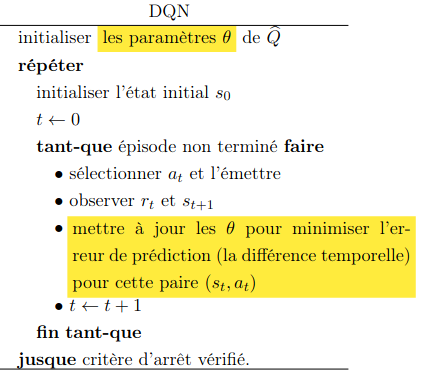

In [104]:
class QNetwork(nn.Module) :
    
    def __init__(self,
              nb_actions,
              nb_observations) : 
        
        super().__init__()
        self.nb_actions = nb_actions
        self.nb_observations = nb_observations
        
        self.net = nn.Sequential(
            nn.Linear(nb_observations, 125),
            nn.ReLU(),
            nn.Linear(125,100),
            nn.ReLU(),
            nn.Linear(100, nb_actions)
        )
        
    def forward(self,x) :
        return self.net(x)

In [105]:
def test(q_network) :
    
    state = env.reset()
    done = False
    cum_sum = 0
    while not done :
        state_t = torch.as_tensor(state , dtype = torch.float32)
        action = torch.argmax(q_network(state_t)).item()
        new_state,reward,done,_ = env.step(action)
        state = new_state
        cum_sum += reward
        
    return cum_sum

In [106]:
# env = gym.make("CartPole-v0")
env = gym.make("LunarLander-v2")
nb_actions = 4
nb_observations = 8

In [107]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
update_frequency = 1

In [108]:

average_list = deque(maxlen=100)

q_network = QNetwork(nb_actions,nb_observations)
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_1 = []
timestep = 0
for episode in tqdm(range(nb_episode)) :
    
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    state = env.reset()
    done = False
    cumul = 0
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32)
        
        if random.random() < 0.1 :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        if timestep % update_frequency == 0:

            done_t = torch.as_tensor(done , dtype = torch.int64)
            new_state_t = torch.as_tensor(new_state , dtype=torch.float32)
            action_t = torch.as_tensor(action , dtype = torch.int64)

            y_target = reward + discount_factor * (1 - done_t) * torch.max(q_network(new_state_t))

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(state_t),dim=0,index=action_t), y_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        state = new_state
        timestep += 1
    
    average_list.append(cumul)
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_1.append(t)

  0%|                                          | 2/1000 [00:00<04:47,  3.48it/s]

episode 0 - test reward : -640.8968204103619 - avg : -201.3834486650577 - epsilon 0.995


  1%|▍                                        | 11/1000 [00:02<05:28,  3.01it/s]

episode 10 - test reward : -790.6642653432835 - avg : -176.16229983207066 - epsilon 0.946354579813443


  2%|▉                                        | 22/1000 [00:05<06:17,  2.59it/s]

episode 20 - test reward : -1542.9764812726264 - avg : -159.4545281341118 - epsilon 0.9000874278732445


  3%|█▎                                       | 31/1000 [00:08<05:36,  2.88it/s]

episode 30 - test reward : -779.8228216933743 - avg : -167.25246898053328 - epsilon 0.8560822709551227


  4%|█▋                                       | 42/1000 [00:10<04:16,  3.74it/s]

episode 40 - test reward : -749.3563506347272 - avg : -188.07734955909237 - epsilon 0.8142285204175609


  5%|██▏                                      | 52/1000 [00:13<08:43,  1.81it/s]

episode 50 - test reward : -812.7191231777512 - avg : -175.24703910184817 - epsilon 0.7744209942832988


  6%|██▌                                      | 62/1000 [00:16<04:38,  3.37it/s]

episode 60 - test reward : -732.348647424668 - avg : -175.76536298784595 - epsilon 0.736559652908221


  7%|██▉                                      | 71/1000 [00:19<08:18,  1.86it/s]

episode 70 - test reward : -633.2615724830591 - avg : -182.48713660284747 - epsilon 0.7005493475733617


  8%|███▎                                     | 82/1000 [00:28<25:13,  1.65s/it]

episode 80 - test reward : -334.3474833135897 - avg : -186.4881553902067 - epsilon 0.6662995813682115


  9%|███▊                                     | 92/1000 [00:34<18:17,  1.21s/it]

episode 90 - test reward : -828.5096238487646 - avg : -185.87005314490315 - epsilon 0.6337242817644086


 10%|████                                    | 102/1000 [00:45<31:25,  2.10s/it]

episode 100 - test reward : -466.5938953731712 - avg : -187.61821010070724 - epsilon 0.6027415843082742


 11%|████▍                                   | 112/1000 [00:48<05:34,  2.66it/s]

episode 110 - test reward : -225.1176956641587 - avg : -185.7020498414451 - epsilon 0.5732736268885887


 12%|████▉                                   | 122/1000 [00:54<17:43,  1.21s/it]

episode 120 - test reward : -534.4514205299421 - avg : -187.33174997159855 - epsilon 0.5452463540625918


 13%|█████▎                                  | 132/1000 [00:58<07:39,  1.89it/s]

episode 130 - test reward : -596.5525017037273 - avg : -187.62207610095547 - epsilon 0.5185893309484582


 14%|█████▋                                  | 142/1000 [01:01<08:05,  1.77it/s]

episode 140 - test reward : -672.9210342941709 - avg : -177.7871043487699 - epsilon 0.4932355662165453


 15%|██████                                  | 152/1000 [01:09<18:29,  1.31s/it]

episode 150 - test reward : -788.2218049400577 - avg : -187.89502625329388 - epsilon 0.46912134373457726


 16%|██████▍                                 | 162/1000 [01:23<39:14,  2.81s/it]

episode 160 - test reward : -352.3216925028314 - avg : -182.68023864985133 - epsilon 0.446186062443672


 17%|██████▉                                 | 172/1000 [01:36<37:23,  2.71s/it]

episode 170 - test reward : -150.45372921798895 - avg : -183.63897181226392 - epsilon 0.42437208406280985


 18%|███████▎                                | 182/1000 [01:38<04:21,  3.13it/s]

episode 180 - test reward : -418.0159940779129 - avg : -170.72550997894294 - epsilon 0.4036245882390106


 19%|███████▋                                | 192/1000 [01:40<03:03,  4.40it/s]

episode 190 - test reward : -168.39002516273675 - avg : -172.8603768850474 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [01:54<51:12,  3.85s/it]

episode 200 - test reward : -335.17854714081415 - avg : -163.49808545599453 - epsilon 0.36512303261753626


 21%|████████▍                               | 212/1000 [02:07<34:13,  2.61s/it]

episode 210 - test reward : -124.49140648937464 - avg : -167.18691612430234 - epsilon 0.3472722151889232


 22%|████████▉                               | 222/1000 [02:09<03:45,  3.45it/s]

episode 220 - test reward : -516.2063119338613 - avg : -167.70593089132674 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [02:25<56:58,  4.45s/it]

episode 230 - test reward : -378.8776635867808 - avg : -167.2361350596211 - epsilon 0.3141460853680822


 24%|█████████▋                              | 242/1000 [02:39<34:07,  2.70s/it]

episode 240 - test reward : -265.050747081466 - avg : -177.57619341646955 - epsilon 0.2987875242397482


 25%|██████████                              | 252/1000 [02:43<10:19,  1.21it/s]

episode 250 - test reward : -379.0989717326406 - avg : -170.91568611243852 - epsilon 0.28417984116121187


 26%|██████████▍                             | 262/1000 [02:56<31:09,  2.53s/it]

episode 260 - test reward : -282.88769753646716 - avg : -174.78514450688846 - epsilon 0.2702863258025825


 27%|██████████▉                             | 272/1000 [02:59<06:30,  1.86it/s]

episode 270 - test reward : -176.54932347034128 - avg : -169.1566735654647 - epsilon 0.2570720625972084


 28%|███████████▎                            | 282/1000 [03:10<26:16,  2.20s/it]

episode 280 - test reward : -174.22094572089935 - avg : -177.74600288180613 - epsilon 0.24450384299593592


 29%|███████████▋                            | 292/1000 [03:12<02:49,  4.19it/s]

episode 290 - test reward : -136.85995923901453 - avg : -175.11858934869463 - epsilon 0.23255008201124722


 30%|████████████                            | 302/1000 [03:16<07:38,  1.52it/s]

episode 300 - test reward : -348.79446403767764 - avg : -179.88219518448466 - epsilon 0.2211807388415433


 31%|████████████▍                           | 312/1000 [03:30<31:17,  2.73s/it]

episode 310 - test reward : -292.01640149770026 - avg : -175.97798781970963 - epsilon 0.21036724137609603


 32%|████████████▉                           | 322/1000 [03:48<41:59,  3.72s/it]

episode 320 - test reward : -142.92921790152656 - avg : -172.14826156077407 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [04:04<53:13,  4.77s/it]

episode 330 - test reward : -137.8014933044372 - avg : -170.8739073371161 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 342/1000 [04:17<26:15,  2.39s/it]

episode 340 - test reward : -177.95535558730685 - avg : -159.46585989374537 - epsilon 0.18099664897669618


 35%|██████████████                          | 352/1000 [04:30<27:08,  2.51s/it]

episode 350 - test reward : -157.86170696401126 - avg : -153.4573840054277 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 362/1000 [04:49<41:56,  3.94s/it]

episode 360 - test reward : -158.59013444568058 - avg : -157.00199659824267 - epsilon 0.16373146555890544


 37%|██████████████▉                         | 372/1000 [05:05<35:12,  3.36s/it]

episode 370 - test reward : -163.24534764521286 - avg : -155.8330566097774 - epsilon 0.1557266555690826


 38%|███████████████▎                        | 382/1000 [05:20<27:07,  2.63s/it]

episode 380 - test reward : -61.01051533017251 - avg : -153.97760403913472 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 392/1000 [05:34<29:02,  2.87s/it]

episode 390 - test reward : -82.57827064390466 - avg : -157.3130633484374 - epsilon 0.14087196468590776


 40%|████████████████                        | 402/1000 [05:36<04:07,  2.41it/s]

episode 400 - test reward : -194.3018706124184 - avg : -153.623312312686 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 412/1000 [05:55<35:38,  3.64s/it]

episode 410 - test reward : -189.24064459200764 - avg : -156.64804625338854 - epsilon 0.12743425563174798


 42%|████████████████▉                       | 422/1000 [06:07<23:53,  2.48s/it]

episode 420 - test reward : -221.04256267090395 - avg : -162.4662192381325 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [06:21<35:02,  3.69s/it]

episode 430 - test reward : -172.08055643447665 - avg : -161.63505512879732 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 442/1000 [06:37<29:37,  3.19s/it]

episode 440 - test reward : -144.0118877356571 - avg : -163.53420952653204 - epsilon 0.10964241905397228


 45%|██████████████████                      | 452/1000 [06:54<28:02,  3.07s/it]

episode 450 - test reward : -162.91532609082128 - avg : -168.9093800512965 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 462/1000 [07:08<24:55,  2.78s/it]

episode 460 - test reward : -194.28749595210684 - avg : -163.6727713999331 - epsilon 0.09918368135888474


 47%|██████████████████▉                     | 472/1000 [07:13<08:46,  1.00it/s]

episode 470 - test reward : -285.07018821432405 - avg : -165.02372860192986 - epsilon 0.0943346041173244


 48%|███████████████████▎                    | 482/1000 [07:23<12:59,  1.51s/it]

episode 480 - test reward : -150.60376497915541 - avg : -167.30950467459235 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 492/1000 [07:39<28:26,  3.36s/it]

episode 490 - test reward : -149.19355636167197 - avg : -161.66302038420355 - epsilon 0.08533607153708872


 50%|████████████████████                    | 502/1000 [07:54<24:44,  2.98s/it]

episode 500 - test reward : -196.6767473486446 - avg : -163.98297872851057 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 511/1000 [08:07<31:02,  3.81s/it]

episode 510 - test reward : -175.55107493677343 - avg : -161.60208006519164 - epsilon 0.07719590465791494


 52%|████████████████████▉                   | 522/1000 [08:23<25:08,  3.16s/it]

episode 520 - test reward : -219.46047811761315 - avg : -160.36157639889547 - epsilon 0.07342180695061275


 53%|█████████████████████▎                  | 532/1000 [08:40<26:49,  3.44s/it]

episode 530 - test reward : -229.63324054264166 - avg : -163.83306619958213 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [08:54<31:23,  4.10s/it]

episode 540 - test reward : -180.68423173779664 - avg : -164.3803506446776 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 552/1000 [09:06<16:49,  2.25s/it]

episode 550 - test reward : -173.0524854760133 - avg : -166.65401806726678 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [09:18<25:35,  3.50s/it]

episode 560 - test reward : -121.35286568087675 - avg : -168.29164487469816 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [09:31<23:34,  3.30s/it]

episode 570 - test reward : -222.161266617164 - avg : -171.2802246369333 - epsilon 0.05714511431233153


 58%|███████████████████████▎                | 582/1000 [09:48<24:53,  3.57s/it]

episode 580 - test reward : -105.95246632610151 - avg : -168.45987837586122 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 592/1000 [10:05<23:18,  3.43s/it]

episode 590 - test reward : -115.71415896708868 - avg : -166.55803600742914 - epsilon 0.05169406930342616


 60%|████████████████████████                | 602/1000 [10:09<05:02,  1.32it/s]

episode 600 - test reward : -75.07030898085699 - avg : -163.41884387330705 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 612/1000 [10:25<19:39,  3.04s/it]

episode 610 - test reward : -125.1503275933479 - avg : -160.98793968516827 - epsilon 0.04676299685992172


 62%|████████████████████████▉               | 622/1000 [10:30<06:15,  1.01it/s]

episode 620 - test reward : -161.37523269626755 - avg : -154.51623265893792 - epsilon 0.04447676004441063


 63%|█████████████████████████▎              | 632/1000 [10:46<20:13,  3.30s/it]

episode 630 - test reward : -138.50379905352779 - avg : -149.98091303685464 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 642/1000 [10:58<13:58,  2.34s/it]

episode 640 - test reward : -214.48256388276815 - avg : -150.56050053796898 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 652/1000 [11:00<01:53,  3.07it/s]

episode 650 - test reward : -146.93613460524756 - avg : -147.2759667880976 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 662/1000 [11:07<06:52,  1.22s/it]

episode 660 - test reward : -429.31089375311 - avg : -145.36988505654622 - epsilon 0.036396227662238566


 67%|██████████████████████████▉             | 672/1000 [11:13<06:01,  1.10s/it]

episode 670 - test reward : -128.72291052643703 - avg : -136.279102547434 - epsilon 0.03461682084029365


 68%|███████████████████████████▎            | 682/1000 [11:15<01:39,  3.20it/s]

episode 680 - test reward : -126.28378738803994 - avg : -138.48248567305535 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 692/1000 [11:32<17:26,  3.40s/it]

episode 690 - test reward : -171.90773157360456 - avg : -140.6510202120024 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 702/1000 [11:45<12:40,  2.55s/it]

episode 700 - test reward : -153.38253586508387 - avg : -151.83207101168932 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [12:00<20:53,  4.34s/it]

episode 710 - test reward : -177.8741463226683 - avg : -155.8356365885539 - epsilon 0.02832764101944931


 72%|████████████████████████████▉           | 722/1000 [12:16<13:55,  3.01s/it]

episode 720 - test reward : -157.30461174813001 - avg : -154.9295887010118 - epsilon 0.02694270634579598


 73%|█████████████████████████████▎          | 732/1000 [12:34<17:00,  3.81s/it]

episode 730 - test reward : -149.75196473757785 - avg : -157.52005227766242 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 742/1000 [12:36<01:19,  3.24it/s]

episode 740 - test reward : -394.5819580627176 - avg : -159.9613438872558 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 752/1000 [12:52<13:47,  3.34s/it]

episode 750 - test reward : -176.83411130170407 - avg : -161.95496539393835 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 762/1000 [13:06<10:37,  2.68s/it]

episode 760 - test reward : -243.50629950839067 - avg : -163.8047486431314 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [13:18<13:02,  3.42s/it]

episode 770 - test reward : -192.81895336669805 - avg : -167.207002982589 - epsilon 0.020969846670345987


 78%|███████████████████████████████▎        | 782/1000 [13:21<02:12,  1.65it/s]

episode 780 - test reward : -350.8599681997808 - avg : -165.51194382060734 - epsilon 0.02


 79%|███████████████████████████████▋        | 792/1000 [13:35<09:48,  2.83s/it]

episode 790 - test reward : -158.68082967890996 - avg : -169.89189136477174 - epsilon 0.02


 80%|████████████████████████████████        | 802/1000 [13:53<11:41,  3.54s/it]

episode 800 - test reward : -91.84338539120957 - avg : -160.66703890511937 - epsilon 0.02


 81%|████████████████████████████████▍       | 812/1000 [14:11<11:43,  3.74s/it]

episode 810 - test reward : -104.90436763136772 - avg : -166.55294722274638 - epsilon 0.02


 82%|████████████████████████████████▉       | 822/1000 [14:26<09:17,  3.13s/it]

episode 820 - test reward : -101.55354290195787 - avg : -169.6563629374182 - epsilon 0.02


 83%|█████████████████████████████████▎      | 832/1000 [14:42<08:23,  3.00s/it]

episode 830 - test reward : -136.81842567309997 - avg : -165.10615008994458 - epsilon 0.02


 84%|█████████████████████████████████▋      | 842/1000 [14:44<00:57,  2.74it/s]

episode 840 - test reward : -173.46954894447202 - avg : -161.52053718492766 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [14:46<00:39,  3.77it/s]

episode 850 - test reward : -78.95806648446438 - avg : -162.705597204525 - epsilon 0.02


 86%|██████████████████████████████████▍     | 862/1000 [15:01<06:43,  2.92s/it]

episode 860 - test reward : -118.82146650555725 - avg : -157.71190863665115 - epsilon 0.02


 87%|██████████████████████████████████▉     | 872/1000 [15:20<08:12,  3.85s/it]

episode 870 - test reward : -125.5231255753109 - avg : -154.79292673440096 - epsilon 0.02


 88%|███████████████████████████████████▎    | 882/1000 [15:30<04:08,  2.10s/it]

episode 880 - test reward : -298.90978025059815 - avg : -155.90824792982724 - epsilon 0.02


 89%|███████████████████████████████████▋    | 892/1000 [15:45<05:15,  2.92s/it]

episode 890 - test reward : -172.2522301464474 - avg : -150.92879802746222 - epsilon 0.02


 90%|████████████████████████████████████    | 902/1000 [15:58<04:32,  2.78s/it]

episode 900 - test reward : -197.71052754084664 - avg : -149.90776053979135 - epsilon 0.02


 91%|████████████████████████████████████▍   | 912/1000 [16:00<00:28,  3.06it/s]

episode 910 - test reward : -130.88234867515362 - avg : -136.29641139542954 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [16:15<05:07,  3.90s/it]

episode 920 - test reward : -171.04777774892062 - avg : -136.66366270542184 - epsilon 0.02


 93%|█████████████████████████████████████▎  | 932/1000 [16:32<03:57,  3.49s/it]

episode 930 - test reward : -159.3496208709404 - avg : -137.6840276512311 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 942/1000 [16:37<00:53,  1.09it/s]

episode 940 - test reward : -274.0669874145682 - avg : -134.9087640151125 - epsilon 0.02


 95%|██████████████████████████████████████  | 952/1000 [16:53<02:40,  3.34s/it]

episode 950 - test reward : -164.39132905346713 - avg : -139.07535578314395 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 962/1000 [17:06<01:38,  2.58s/it]

episode 960 - test reward : -191.20108970181198 - avg : -144.4378160965737 - epsilon 0.02


 97%|██████████████████████████████████████▉ | 972/1000 [17:18<01:08,  2.44s/it]

episode 970 - test reward : -221.07221798668007 - avg : -145.4714679782203 - epsilon 0.02


 98%|███████████████████████████████████████▎| 982/1000 [17:22<00:11,  1.57it/s]

episode 980 - test reward : -167.8997705956038 - avg : -140.99651060505417 - epsilon 0.02


 99%|███████████████████████████████████████▋| 992/1000 [17:34<00:18,  2.26s/it]

episode 990 - test reward : -261.00568393926363 - avg : -140.15195444443668 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [17:36<00:00,  1.06s/it]


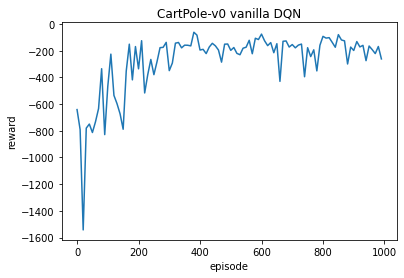

In [109]:
plt.figure()
plt.title("CartPole-v0 vanilla DQN")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_1)
plt.show()

## DQN with Experience Replay Buffer

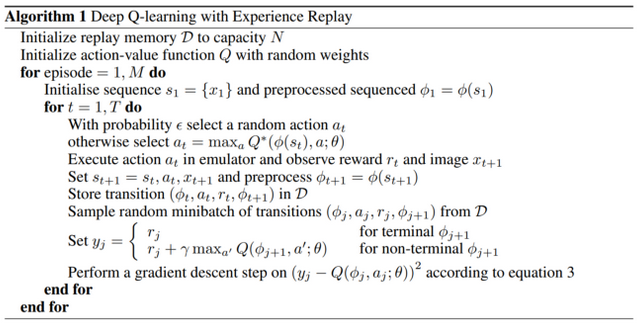

In [110]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = 10000
update_frequency = 1

In [111]:


replay_buffer = deque(maxlen=size_replay_buffer)
q_network = QNetwork(nb_actions,nb_observations)

timestep = 0

optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_2 = []

average_list = deque(maxlen=100)
for episode in tqdm(range(nb_episode)) :
    state = env.reset()
    done = False
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32)
        
        if random.random() < epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        
        cumul += reward
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
        
            
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)

            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32)
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.max(q_network(new_states_t),dim=1)[0]

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        state = new_state
        timestep += 1
    
    average_list.append(cumul)
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_2.append(t)

  0%|                                          | 2/1000 [00:00<03:01,  5.49it/s]

episode 0 - test reward : -630.5476819793967 - avg : -198.02787196734576 - epsilon 0.995


  1%|▍                                        | 11/1000 [00:02<04:07,  3.99it/s]

episode 10 - test reward : -194.49971649066833 - avg : -268.48165420497975 - epsilon 0.946354579813443


  2%|▊                                        | 21/1000 [00:04<03:17,  4.95it/s]

episode 20 - test reward : -91.70448777715198 - avg : -198.44559666388852 - epsilon 0.9000874278732445


  3%|█▎                                       | 31/1000 [00:07<06:25,  2.52it/s]

episode 30 - test reward : -43.488189600844116 - avg : -158.49751237902277 - epsilon 0.8560822709551227


  4%|█▌                                     | 41/1000 [00:34<1:45:43,  6.61s/it]

episode 40 - test reward : -159.18541901346924 - avg : -137.63556948686391 - epsilon 0.8142285204175609


  5%|█▉                                     | 51/1000 [01:02<1:02:25,  3.95s/it]

episode 50 - test reward : -172.55890846576062 - avg : -134.58055536926793 - epsilon 0.7744209942832988


  6%|██▌                                      | 61/1000 [01:21<59:50,  3.82s/it]

episode 60 - test reward : -153.14889009868642 - avg : -137.0307095759313 - epsilon 0.736559652908221


  7%|██▉                                      | 71/1000 [01:35<38:53,  2.51s/it]

episode 70 - test reward : 91.03452627656074 - avg : -129.25615290743275 - epsilon 0.7005493475733617


  8%|███▎                                     | 81/1000 [01:55<43:05,  2.81s/it]

episode 80 - test reward : -12.191849354014213 - avg : -119.36172720409029 - epsilon 0.6662995813682115


  9%|███▋                                     | 91/1000 [02:11<48:15,  3.19s/it]

episode 90 - test reward : -66.09166183470207 - avg : -113.7838871275171 - epsilon 0.6337242817644086


 10%|████                                    | 101/1000 [02:26<47:16,  3.15s/it]

episode 100 - test reward : -65.51550391316509 - avg : -101.17598462029656 - epsilon 0.6027415843082742


 11%|████▏                                 | 111/1000 [02:45<1:00:56,  4.11s/it]

episode 110 - test reward : 3.5578415547050666 - avg : -79.28684588009993 - epsilon 0.5732736268885887


 12%|████▊                                   | 121/1000 [03:02<50:19,  3.43s/it]

episode 120 - test reward : 0.1903205017115738 - avg : -73.96379223759912 - epsilon 0.5452463540625918


 13%|████▉                                 | 131/1000 [03:28<1:15:44,  5.23s/it]

episode 130 - test reward : -34.657261879136435 - avg : -72.53880330072774 - epsilon 0.5185893309484582


 14%|█████▋                                  | 141/1000 [03:45<46:17,  3.23s/it]

episode 140 - test reward : 44.67920647741913 - avg : -71.40455062990176 - epsilon 0.4932355662165453


 15%|█████▋                                | 151/1000 [04:05<1:09:10,  4.89s/it]

episode 150 - test reward : -91.94511751703156 - avg : -59.775634514804025 - epsilon 0.46912134373457726


 16%|██████▍                                 | 161/1000 [04:22<58:52,  4.21s/it]

episode 160 - test reward : -85.74576969926035 - avg : -52.15990567773946 - epsilon 0.446186062443672


 17%|██████▊                                 | 171/1000 [04:39<55:09,  3.99s/it]

episode 170 - test reward : -101.77430519085603 - avg : -47.15531945421557 - epsilon 0.42437208406280985


 18%|██████▉                               | 181/1000 [04:59<1:10:36,  5.17s/it]

episode 180 - test reward : -83.07568593215083 - avg : -51.848987256788774 - epsilon 0.4036245882390106


 19%|███████▋                                | 191/1000 [05:14<54:40,  4.06s/it]

episode 190 - test reward : -70.32802007866145 - avg : -55.56939193176982 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [05:29<52:29,  3.94s/it]

episode 200 - test reward : -145.54234386185016 - avg : -60.941040883177294 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [05:43<47:56,  3.65s/it]

episode 210 - test reward : -98.17097569879311 - avg : -66.53576957837616 - epsilon 0.3472722151889232


 22%|████████▊                               | 221/1000 [05:59<56:00,  4.31s/it]

episode 220 - test reward : -153.06655900021832 - avg : -65.42972535199992 - epsilon 0.3302941218954743


 23%|████████▊                             | 231/1000 [06:17<1:05:06,  5.08s/it]

episode 230 - test reward : -106.15242874461646 - avg : -68.23664139942834 - epsilon 0.3141460853680822


 24%|█████████▋                              | 241/1000 [06:33<54:39,  4.32s/it]

episode 240 - test reward : -79.1751184498874 - avg : -70.78434217091842 - epsilon 0.2987875242397482


 25%|██████████                              | 251/1000 [06:49<54:03,  4.33s/it]

episode 250 - test reward : -125.06511990629572 - avg : -79.99897848231488 - epsilon 0.28417984116121187


 26%|██████████▍                             | 261/1000 [07:03<47:04,  3.82s/it]

episode 260 - test reward : -101.4325166541213 - avg : -80.74076765982916 - epsilon 0.2702863258025825


 27%|██████████▎                           | 271/1000 [07:21<1:00:04,  4.94s/it]

episode 270 - test reward : -151.5395552869084 - avg : -89.34786134984734 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [07:34<43:46,  3.65s/it]

episode 280 - test reward : -119.62809246754087 - avg : -92.84935044718556 - epsilon 0.24450384299593592


 29%|███████████                           | 291/1000 [07:54<1:00:42,  5.14s/it]

episode 290 - test reward : -8.463321913824796 - avg : -91.53495293053474 - epsilon 0.23255008201124722


 30%|████████████                            | 302/1000 [08:06<26:38,  2.29s/it]

episode 300 - test reward : -11.077043404906874 - avg : -97.47820661328834 - epsilon 0.2211807388415433


 31%|████████████▍                           | 312/1000 [08:18<26:07,  2.28s/it]

episode 310 - test reward : -12.203680653855935 - avg : -99.14734391678216 - epsilon 0.21036724137609603


 32%|████████████▊                           | 321/1000 [08:37<57:51,  5.11s/it]

episode 320 - test reward : -162.68391468231297 - avg : -107.84811971785744 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [08:45<24:19,  2.18s/it]

episode 330 - test reward : 28.387650038538197 - avg : -109.93927415951781 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 341/1000 [09:00<38:38,  3.52s/it]

episode 340 - test reward : -144.42118258601914 - avg : -109.59065212554246 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [09:11<33:36,  3.11s/it]

episode 350 - test reward : -266.14519448556996 - avg : -110.51719681463835 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 361/1000 [09:23<32:42,  3.07s/it]

episode 360 - test reward : -128.9683128613248 - avg : -113.96676921545445 - epsilon 0.16373146555890544


 37%|██████████████▊                         | 371/1000 [09:30<16:56,  1.62s/it]

episode 370 - test reward : 80.56498104094324 - avg : -119.54209370115173 - epsilon 0.1557266555690826


 38%|███████████████▎                        | 382/1000 [09:41<20:59,  2.04s/it]

episode 380 - test reward : -53.58444362828358 - avg : -116.2845480583626 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 392/1000 [09:49<15:39,  1.55s/it]

episode 390 - test reward : -240.3341973082639 - avg : -113.76706376754692 - epsilon 0.14087196468590776


 40%|████████████████                        | 402/1000 [09:53<07:24,  1.34it/s]

episode 400 - test reward : -129.9137796025836 - avg : -116.02284848173727 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [10:05<31:55,  3.25s/it]

episode 410 - test reward : -115.3291968825043 - avg : -115.12806631495465 - epsilon 0.12743425563174798


 42%|████████████████▉                       | 422/1000 [10:13<12:36,  1.31s/it]

episode 420 - test reward : -137.84492293876022 - avg : -116.40790081538289 - epsilon 0.12120401149972035


 43%|█████████████████▎                      | 432/1000 [10:23<18:31,  1.96s/it]

episode 430 - test reward : -249.52924787578195 - avg : -116.63927127582845 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [10:26<04:58,  1.87it/s]

episode 440 - test reward : -141.6905147894548 - avg : -121.6517715921595 - epsilon 0.10964241905397228


 45%|██████████████████                      | 452/1000 [10:29<03:58,  2.30it/s]

episode 450 - test reward : -95.10473541637268 - avg : -123.5740913558304 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 462/1000 [10:33<04:56,  1.81it/s]

episode 460 - test reward : -109.6551370290028 - avg : -125.69418982340977 - epsilon 0.09918368135888474


 47%|██████████████████▉                     | 472/1000 [10:36<02:49,  3.12it/s]

episode 470 - test reward : -110.60270197376249 - avg : -120.56559341277061 - epsilon 0.0943346041173244


 48%|███████████████████▎                    | 482/1000 [10:39<04:26,  1.95it/s]

episode 480 - test reward : -248.2532879921152 - avg : -120.82428146280357 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [10:43<05:19,  1.59it/s]

episode 490 - test reward : -99.34188495879344 - avg : -130.6806225482431 - epsilon 0.08533607153708872


 50%|████████████████████                    | 502/1000 [10:46<03:58,  2.09it/s]

episode 500 - test reward : -333.33626112974787 - avg : -130.97528165000105 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 512/1000 [10:50<04:48,  1.69it/s]

episode 510 - test reward : -151.32076653992902 - avg : -134.6484450223547 - epsilon 0.07719590465791494


 52%|████████████████████▉                   | 522/1000 [10:55<06:31,  1.22it/s]

episode 520 - test reward : -158.80792330246769 - avg : -133.6678905387858 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [11:00<09:10,  1.17s/it]

episode 530 - test reward : -185.27876234097704 - avg : -135.84643411117963 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 542/1000 [11:05<05:06,  1.49it/s]

episode 540 - test reward : -201.50870704529657 - avg : -136.79377136886637 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 552/1000 [11:07<02:57,  2.52it/s]

episode 550 - test reward : -66.11142407128918 - avg : -137.16304840286273 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 562/1000 [11:12<05:15,  1.39it/s]

episode 560 - test reward : -439.53299915558375 - avg : -139.99644083882703 - epsilon 0.06008254194952879


 57%|██████████████████████▉                 | 572/1000 [11:15<04:13,  1.69it/s]

episode 570 - test reward : -327.1813644451725 - avg : -139.59857453638432 - epsilon 0.05714511431233153


 58%|███████████████████████▏                | 581/1000 [11:18<04:10,  1.67it/s]

episode 580 - test reward : -170.2696056512626 - avg : -141.85936874560096 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [11:21<03:07,  2.18it/s]

episode 590 - test reward : -186.94043309382738 - avg : -138.26110407287047 - epsilon 0.05169406930342616


 60%|████████████████████████                | 602/1000 [11:30<10:21,  1.56s/it]

episode 600 - test reward : -200.5920782053588 - avg : -134.74838989827444 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [11:33<03:27,  1.87it/s]

episode 610 - test reward : -388.5512383172419 - avg : -132.4061170302149 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [11:37<04:06,  1.54it/s]

episode 620 - test reward : -70.83652048130469 - avg : -133.66484111981018 - epsilon 0.04447676004441063


 63%|█████████████████████████▎              | 632/1000 [11:40<02:23,  2.57it/s]

episode 630 - test reward : -217.47830470530462 - avg : -137.38097325991959 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 642/1000 [11:43<02:23,  2.50it/s]

episode 640 - test reward : -461.5640549494087 - avg : -133.90054866903122 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 652/1000 [11:46<02:23,  2.42it/s]

episode 650 - test reward : -205.9494865281982 - avg : -139.92111406119366 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 662/1000 [11:49<02:29,  2.26it/s]

episode 660 - test reward : -240.2341264205245 - avg : -138.7938111762467 - epsilon 0.036396227662238566


 67%|██████████████████████████▉             | 672/1000 [11:52<02:22,  2.31it/s]

episode 670 - test reward : -346.22746633297953 - avg : -140.96854769532084 - epsilon 0.03461682084029365


 68%|███████████████████████████▏            | 681/1000 [11:55<02:34,  2.06it/s]

episode 680 - test reward : -268.5972113267428 - avg : -141.78913454422533 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 692/1000 [11:58<01:45,  2.92it/s]

episode 690 - test reward : -106.7725615537909 - avg : -144.04570631857018 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 702/1000 [12:01<02:02,  2.43it/s]

episode 700 - test reward : -223.59048278221024 - avg : -155.99910968621035 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [12:03<01:38,  2.93it/s]

episode 710 - test reward : -169.414006324711 - avg : -159.67357072324495 - epsilon 0.02832764101944931


 72%|████████████████████████████▉           | 722/1000 [12:06<01:27,  3.17it/s]

episode 720 - test reward : -105.60488499593502 - avg : -158.31841011944437 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [12:09<02:04,  2.15it/s]

episode 730 - test reward : -311.46778345111596 - avg : -162.14629996910887 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 742/1000 [12:12<01:31,  2.81it/s]

episode 740 - test reward : -62.88419323686086 - avg : -166.5057726611896 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 752/1000 [12:15<01:23,  2.95it/s]

episode 750 - test reward : -59.56857746719703 - avg : -161.40407934449522 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [12:18<02:04,  1.93it/s]

episode 760 - test reward : -233.27054091810447 - avg : -166.0421133909627 - epsilon 0.022047758717570132


 77%|██████████████████████████████▉         | 772/1000 [12:21<01:27,  2.60it/s]

episode 770 - test reward : -106.94766008825414 - avg : -165.88047302980198 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [12:24<01:16,  2.87it/s]

episode 780 - test reward : -76.49621856519745 - avg : -170.6925826818794 - epsilon 0.02


 79%|███████████████████████████████▋        | 792/1000 [12:27<01:39,  2.09it/s]

episode 790 - test reward : -388.3073194527154 - avg : -173.98283832204586 - epsilon 0.02


 80%|████████████████████████████████        | 802/1000 [12:30<01:10,  2.83it/s]

episode 800 - test reward : -101.08627145293681 - avg : -166.70358555943037 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [12:36<04:19,  1.37s/it]

episode 810 - test reward : -146.87835945465892 - avg : -163.6148320621094 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [12:38<01:16,  2.35it/s]

episode 820 - test reward : -212.10862476626767 - avg : -159.1721941690756 - epsilon 0.02


 83%|█████████████████████████████████▎      | 832/1000 [12:42<01:04,  2.59it/s]

episode 830 - test reward : -137.31682003581403 - avg : -153.37405300163584 - epsilon 0.02


 84%|█████████████████████████████████▋      | 842/1000 [12:45<01:17,  2.03it/s]

episode 840 - test reward : -84.62074476268286 - avg : -156.62485525678505 - epsilon 0.02


 85%|██████████████████████████████████      | 852/1000 [12:48<00:59,  2.50it/s]

episode 850 - test reward : -77.60272201615349 - avg : -156.42581684113878 - epsilon 0.02


 86%|██████████████████████████████████▍     | 862/1000 [12:50<00:36,  3.74it/s]

episode 860 - test reward : -81.60078911131582 - avg : -149.91441997903095 - epsilon 0.02


 87%|██████████████████████████████████▉     | 872/1000 [12:54<00:58,  2.19it/s]

episode 870 - test reward : -65.55784819133967 - avg : -154.77465145933357 - epsilon 0.02


 88%|███████████████████████████████████▎    | 882/1000 [12:58<01:29,  1.31it/s]

episode 880 - test reward : -236.45992606525928 - avg : -153.9696864700323 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [13:01<01:07,  1.61it/s]

episode 890 - test reward : -78.38946661105845 - avg : -150.83997681417983 - epsilon 0.02


 90%|████████████████████████████████████    | 902/1000 [13:05<00:40,  2.42it/s]

episode 900 - test reward : -67.23862682044981 - avg : -153.499987951684 - epsilon 0.02


 91%|████████████████████████████████████▍   | 912/1000 [13:10<01:17,  1.14it/s]

episode 910 - test reward : -107.59721222657397 - avg : -156.21695056574353 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [13:13<00:34,  2.27it/s]

episode 920 - test reward : -45.89850584026403 - avg : -165.2027435116487 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [13:16<00:49,  1.38it/s]

episode 930 - test reward : -58.016659392849775 - avg : -164.44261261608955 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 942/1000 [13:19<00:19,  2.99it/s]

episode 940 - test reward : -58.69570994699594 - avg : -161.68920423839808 - epsilon 0.02


 95%|██████████████████████████████████████  | 952/1000 [13:22<00:20,  2.37it/s]

episode 950 - test reward : -62.72820843029738 - avg : -162.44363884566675 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 962/1000 [13:25<00:14,  2.64it/s]

episode 960 - test reward : -96.22048338993726 - avg : -164.08488488462865 - epsilon 0.02


 97%|██████████████████████████████████████▉ | 972/1000 [13:28<00:10,  2.73it/s]

episode 970 - test reward : -16.49777589788649 - avg : -160.12532626418843 - epsilon 0.02


 98%|███████████████████████████████████████▎| 982/1000 [13:33<00:14,  1.21it/s]

episode 980 - test reward : -91.75165059214014 - avg : -158.14590088504613 - epsilon 0.02


 99%|███████████████████████████████████████▋| 992/1000 [13:35<00:02,  3.31it/s]

episode 990 - test reward : -51.78693517901551 - avg : -157.37640820850223 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [13:37<00:00,  1.22it/s]


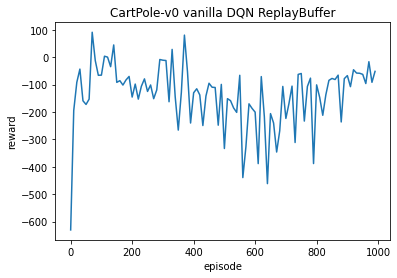

In [112]:
plt.figure()
plt.title("CartPole-v0 vanilla DQN ReplayBuffer")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_2)
plt.show()

## DQN with Experience Replay Buffer and Target Network

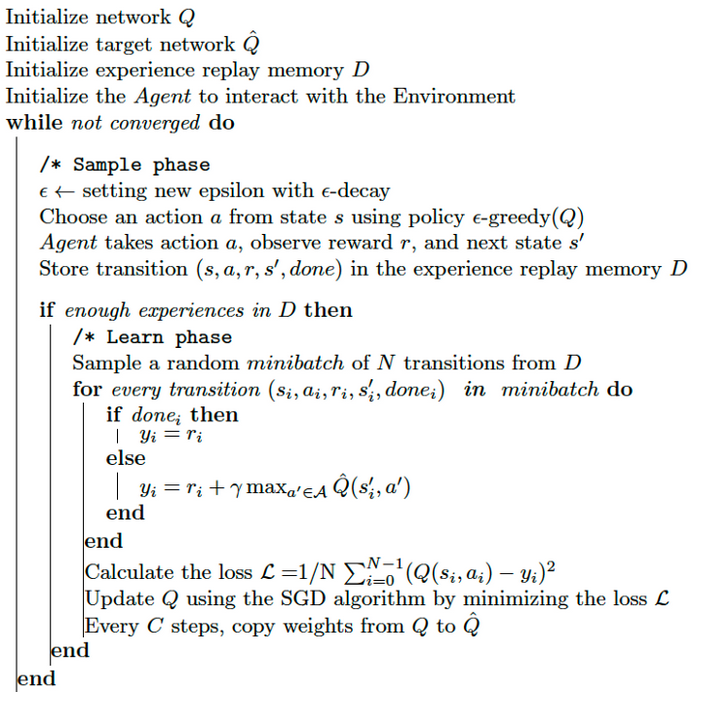

In [113]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1

tau = 1e-3 

In [114]:
replay_buffer = deque(maxlen=size_replay_buffer)
q_network = QNetwork(nb_actions,nb_observations)
q_target_network = QNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_3 = []
average_list = deque(maxlen=100)
timestep = 0


for episode in tqdm(range(nb_episode)) :
    
    
    state = env.reset()
    done = False
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32)
        
        if random.random() < epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
        
            
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)

            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32)
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.max(q_target_network(new_states_t),dim=1)[0].detach()

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
        timestep += 1
        
        state = new_state
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_3.append(t)

  0%|                                          | 2/1000 [00:00<04:08,  4.01it/s]

episode 0 - test reward : -481.69491067435354 - avg : -495.61603190554337 - epsilon 0.995


  1%|▍                                        | 12/1000 [00:02<03:35,  4.59it/s]

episode 10 - test reward : -498.2793287410688 - avg : -311.98398600743235 - epsilon 0.946354579813443


  2%|▉                                        | 22/1000 [00:04<03:27,  4.71it/s]

episode 20 - test reward : -349.67991414559947 - avg : -353.7139007890596 - epsilon 0.9000874278732445


  3%|█▎                                       | 31/1000 [00:06<04:07,  3.92it/s]

episode 30 - test reward : -170.7992038321377 - avg : -308.4646528956513 - epsilon 0.8560822709551227


  4%|█▋                                       | 42/1000 [00:08<04:45,  3.36it/s]

episode 40 - test reward : -103.26687499380564 - avg : -267.7359878581965 - epsilon 0.8142285204175609


  5%|█▉                                     | 51/1000 [00:32<1:32:48,  5.87s/it]

episode 50 - test reward : -176.88756697549314 - avg : -238.9727212278507 - epsilon 0.7744209942832988


  6%|██▍                                    | 61/1000 [01:08<1:54:38,  7.33s/it]

episode 60 - test reward : -91.13742854602415 - avg : -221.69488541626427 - epsilon 0.736559652908221


  7%|██▊                                    | 71/1000 [01:45<1:47:57,  6.97s/it]

episode 70 - test reward : -81.94587221790609 - avg : -202.20956762098706 - epsilon 0.7005493475733617


  8%|███▏                                   | 81/1000 [02:18<1:17:09,  5.04s/it]

episode 80 - test reward : -80.48133606376614 - avg : -185.6716693824218 - epsilon 0.6662995813682115


  9%|███▌                                   | 91/1000 [02:59<1:48:28,  7.16s/it]

episode 90 - test reward : -79.13353669372603 - avg : -169.10564162004235 - epsilon 0.6337242817644086


 10%|███▊                                  | 101/1000 [03:36<1:34:30,  6.31s/it]

episode 100 - test reward : -62.36685139052129 - avg : -151.0806860015021 - epsilon 0.6027415843082742


 11%|████▏                                 | 111/1000 [04:13<1:36:11,  6.49s/it]

episode 110 - test reward : -161.07753389982014 - avg : -122.29426996949988 - epsilon 0.5732736268885887


 12%|████▌                                 | 121/1000 [04:39<1:07:55,  4.64s/it]

episode 120 - test reward : -214.65614568523893 - avg : -78.15429604918111 - epsilon 0.5452463540625918


 13%|████▉                                 | 131/1000 [05:04<1:07:43,  4.68s/it]

episode 130 - test reward : -103.36978766489817 - avg : -57.2793994229814 - epsilon 0.5185893309484582


 14%|█████▎                                | 141/1000 [05:24<1:03:56,  4.47s/it]

episode 140 - test reward : -70.49334918290299 - avg : -48.39962429124619 - epsilon 0.4932355662165453


 15%|█████▋                                | 151/1000 [05:52<1:20:02,  5.66s/it]

episode 150 - test reward : 28.9659753336182 - avg : -35.41309283237351 - epsilon 0.46912134373457726


 16%|██████                                | 161/1000 [06:16<1:12:38,  5.19s/it]

episode 160 - test reward : -36.24073732440051 - avg : -26.85346818627025 - epsilon 0.446186062443672


 17%|██████▉                                 | 172/1000 [06:35<36:09,  2.62s/it]

episode 170 - test reward : -111.10435618711168 - avg : -21.446579133415025 - epsilon 0.42437208406280985


 18%|███████▏                                | 181/1000 [06:49<47:09,  3.45s/it]

episode 180 - test reward : -107.76571521158758 - avg : -18.192904352476614 - epsilon 0.4036245882390106


 19%|███████▋                                | 191/1000 [07:04<55:07,  4.09s/it]

episode 190 - test reward : -130.94618840887924 - avg : -21.416629197581468 - epsilon 0.38389143477919885


 20%|███████▋                              | 201/1000 [07:22<1:03:03,  4.74s/it]

episode 200 - test reward : -21.641317091508316 - avg : -23.878073963113994 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [07:28<17:35,  1.34s/it]

episode 210 - test reward : -118.08782378380536 - avg : -28.309983726748086 - epsilon 0.3472722151889232


 22%|████████▍                             | 221/1000 [07:46<1:06:00,  5.08s/it]

episode 220 - test reward : -86.31372504896167 - avg : -39.725991583646724 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [08:03<57:05,  4.45s/it]

episode 230 - test reward : -129.65955863884062 - avg : -46.29172879945742 - epsilon 0.3141460853680822


 24%|█████████▏                            | 241/1000 [08:20<1:01:05,  4.83s/it]

episode 240 - test reward : -45.69919432276047 - avg : -50.638490400421375 - epsilon 0.2987875242397482


 25%|██████████                              | 252/1000 [08:38<41:28,  3.33s/it]

episode 250 - test reward : -79.69567503290483 - avg : -60.245193494063734 - epsilon 0.28417984116121187


 26%|█████████▉                            | 261/1000 [08:55<1:00:15,  4.89s/it]

episode 260 - test reward : -60.478372413451964 - avg : -63.27325256677759 - epsilon 0.2702863258025825


 27%|██████████▊                             | 271/1000 [09:11<52:17,  4.30s/it]

episode 270 - test reward : -38.81166780341885 - avg : -67.27242697244476 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [09:23<39:04,  3.26s/it]

episode 280 - test reward : -91.68825128360541 - avg : -69.29700595233872 - epsilon 0.24450384299593592


 29%|███████████▋                            | 292/1000 [09:37<30:06,  2.55s/it]

episode 290 - test reward : -113.92678977223086 - avg : -70.09680353616609 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [09:48<33:58,  2.92s/it]

episode 300 - test reward : -123.03331473665303 - avg : -74.66674543177926 - epsilon 0.2211807388415433


 31%|████████████▍                           | 311/1000 [10:03<48:58,  4.26s/it]

episode 310 - test reward : -77.8162645544403 - avg : -79.41700796573106 - epsilon 0.21036724137609603


 32%|████████████▉                           | 322/1000 [10:22<35:37,  3.15s/it]

episode 320 - test reward : -41.26549685625854 - avg : -80.09920056937405 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [10:33<36:04,  3.24s/it]

episode 330 - test reward : -74.25043874785281 - avg : -84.63835134529542 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 342/1000 [10:51<37:12,  3.39s/it]

episode 340 - test reward : -59.00418642464764 - avg : -84.88592658381005 - epsilon 0.18099664897669618


 35%|██████████████                          | 352/1000 [11:05<29:42,  2.75s/it]

episode 350 - test reward : -78.60132138771762 - avg : -87.71930990907406 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 362/1000 [11:19<29:29,  2.77s/it]

episode 360 - test reward : -36.19778119142499 - avg : -89.7408130138296 - epsilon 0.16373146555890544


 37%|██████████████▉                         | 372/1000 [11:26<11:52,  1.13s/it]

episode 370 - test reward : -116.46917598381404 - avg : -91.7459395528096 - epsilon 0.1557266555690826


 38%|███████████████▎                        | 382/1000 [11:38<23:21,  2.27s/it]

episode 380 - test reward : -103.25069609153127 - avg : -93.37057251816765 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 392/1000 [11:47<17:58,  1.77s/it]

episode 390 - test reward : -48.35483093726775 - avg : -98.22210272806664 - epsilon 0.14087196468590776


 40%|████████████████                        | 401/1000 [12:01<35:55,  3.60s/it]

episode 400 - test reward : -65.61599380899217 - avg : -99.12897932157934 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 412/1000 [12:18<33:04,  3.37s/it]

episode 410 - test reward : -85.17917360939634 - avg : -98.79298767989587 - epsilon 0.12743425563174798


 42%|████████████████▉                       | 422/1000 [12:33<28:56,  3.00s/it]

episode 420 - test reward : -74.35601733612721 - avg : -101.31408033031158 - epsilon 0.12120401149972035


 43%|█████████████████▎                      | 432/1000 [12:41<12:22,  1.31s/it]

episode 430 - test reward : -110.6581939482949 - avg : -100.2043581041675 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 442/1000 [12:53<22:23,  2.41s/it]

episode 440 - test reward : -104.51382589017678 - avg : -105.52745321375215 - epsilon 0.10964241905397228


 45%|██████████████████                      | 452/1000 [12:59<09:01,  1.01it/s]

episode 450 - test reward : -97.73948894327859 - avg : -108.28270884545336 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 462/1000 [13:12<21:46,  2.43s/it]

episode 460 - test reward : -45.31988464028123 - avg : -107.01030093486575 - epsilon 0.09918368135888474


 47%|██████████████████▉                     | 472/1000 [13:25<22:46,  2.59s/it]

episode 470 - test reward : -67.54008295827119 - avg : -111.0802863790977 - epsilon 0.0943346041173244


 48%|███████████████████▏                    | 481/1000 [13:40<35:34,  4.11s/it]

episode 480 - test reward : -63.264330417292356 - avg : -113.96277155193087 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 492/1000 [13:51<16:51,  1.99s/it]

episode 490 - test reward : -65.41714311307364 - avg : -116.60447362860306 - epsilon 0.08533607153708872


 50%|████████████████████                    | 502/1000 [13:59<12:05,  1.46s/it]

episode 500 - test reward : -109.29162632627019 - avg : -121.21000545877949 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 512/1000 [14:14<23:36,  2.90s/it]

episode 510 - test reward : -61.89200440229657 - avg : -123.69084332948704 - epsilon 0.07719590465791494


 52%|████████████████████▊                   | 521/1000 [14:26<28:28,  3.57s/it]

episode 520 - test reward : -96.54171841835401 - avg : -123.90121082769261 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [14:34<15:44,  2.01s/it]

episode 530 - test reward : -143.76622892961134 - avg : -126.41169534545173 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [14:47<25:23,  3.32s/it]

episode 540 - test reward : -39.40350098226505 - avg : -129.1537680274667 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 552/1000 [15:01<19:15,  2.58s/it]

episode 550 - test reward : -86.93492322641485 - avg : -130.21401100274718 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [15:17<32:24,  4.43s/it]

episode 560 - test reward : -101.32404306096912 - avg : -135.62944974143016 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [15:31<28:27,  3.98s/it]

episode 570 - test reward : -80.17773787118274 - avg : -137.55918135171146 - epsilon 0.05714511431233153


 58%|███████████████████████▎                | 582/1000 [15:45<18:29,  2.65s/it]

episode 580 - test reward : -34.229530228802474 - avg : -145.96703900686066 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [15:59<26:44,  3.92s/it]

episode 590 - test reward : -72.4337068311894 - avg : -145.68023357617 - epsilon 0.05169406930342616


 60%|████████████████████████                | 601/1000 [16:14<26:56,  4.05s/it]

episode 600 - test reward : -83.8831907398367 - avg : -148.97538227697666 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 612/1000 [16:30<20:06,  3.11s/it]

episode 610 - test reward : -40.16270690925722 - avg : -152.79127373749313 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [16:46<28:43,  4.55s/it]

episode 620 - test reward : -29.615451324028488 - avg : -156.35650094538715 - epsilon 0.04447676004441063


 63%|█████████████████████████▎              | 632/1000 [17:01<18:44,  3.06s/it]

episode 630 - test reward : -14.798795258102782 - avg : -153.86221453435886 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 642/1000 [17:16<17:21,  2.91s/it]

episode 640 - test reward : -36.82827080984073 - avg : -152.16738851930745 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 652/1000 [17:31<16:58,  2.93s/it]

episode 650 - test reward : -14.770067233698153 - avg : -154.24415568540454 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 662/1000 [17:48<19:16,  3.42s/it]

episode 660 - test reward : -11.452402929347281 - avg : -158.58003467788146 - epsilon 0.036396227662238566


 67%|██████████████████████████▉             | 672/1000 [18:05<18:55,  3.46s/it]

episode 670 - test reward : -30.723358326648643 - avg : -158.79599092868025 - epsilon 0.03461682084029365


 68%|███████████████████████████▎            | 682/1000 [18:18<12:56,  2.44s/it]

episode 680 - test reward : 83.13326417258477 - avg : -151.02958854920269 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [18:35<24:00,  4.66s/it]

episode 690 - test reward : 19.9308158975622 - avg : -154.38390537242122 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [18:44<11:37,  2.33s/it]

episode 700 - test reward : 114.15121440412322 - avg : -149.687541661444 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [18:59<20:18,  4.22s/it]

episode 710 - test reward : 3.227935280776818 - avg : -153.41387078467105 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [19:17<23:13,  5.00s/it]

episode 720 - test reward : -6.94688014839168 - avg : -156.96380907033233 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [19:29<14:02,  3.13s/it]

episode 730 - test reward : -27.922206542055495 - avg : -162.28785168996856 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 741/1000 [19:42<15:13,  3.53s/it]

episode 740 - test reward : -32.41977387103087 - avg : -158.64788100233085 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [19:55<14:45,  3.56s/it]

episode 750 - test reward : 26.17900274583409 - avg : -158.06317390146106 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 762/1000 [20:06<08:25,  2.13s/it]

episode 760 - test reward : 44.9380794906524 - avg : -160.5704851699021 - epsilon 0.022047758717570132


 77%|██████████████████████████████▉         | 772/1000 [20:20<10:18,  2.71s/it]

episode 770 - test reward : 46.152130387925 - avg : -158.32710405014558 - epsilon 0.020969846670345987


 78%|███████████████████████████████▎        | 782/1000 [20:37<12:25,  3.42s/it]

episode 780 - test reward : 37.869662865717096 - avg : -166.06523001959766 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [20:51<12:59,  3.73s/it]

episode 790 - test reward : 62.92544379924739 - avg : -161.29679297018419 - epsilon 0.02


 80%|████████████████████████████████        | 802/1000 [21:10<12:21,  3.74s/it]

episode 800 - test reward : -1.6807279292034345 - avg : -162.60053347773822 - epsilon 0.02


 81%|████████████████████████████████▍       | 812/1000 [21:23<08:20,  2.66s/it]

episode 810 - test reward : 42.311268345310076 - avg : -159.0632499313071 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [21:42<15:21,  5.15s/it]

episode 820 - test reward : -7.298423115509543 - avg : -157.60091626288576 - epsilon 0.02


 83%|█████████████████████████████████▎      | 832/1000 [21:57<08:05,  2.89s/it]

episode 830 - test reward : 15.886098092053288 - avg : -160.6066472253695 - epsilon 0.02


 84%|█████████████████████████████████▋      | 841/1000 [22:06<06:03,  2.28s/it]

episode 840 - test reward : 181.98121065915822 - avg : -162.73387528452858 - epsilon 0.02


 85%|██████████████████████████████████      | 852/1000 [22:23<08:11,  3.32s/it]

episode 850 - test reward : 56.877731354203675 - avg : -160.44555026917232 - epsilon 0.02


 86%|██████████████████████████████████▍     | 862/1000 [22:40<07:45,  3.37s/it]

episode 860 - test reward : 6.875760147315118 - avg : -161.93933270159488 - epsilon 0.02


 87%|██████████████████████████████████▉     | 872/1000 [22:55<06:38,  3.11s/it]

episode 870 - test reward : 1.4099422153808245 - avg : -166.7979591071449 - epsilon 0.02


 88%|███████████████████████████████████▏    | 881/1000 [23:08<06:48,  3.44s/it]

episode 880 - test reward : 74.15545614407372 - avg : -162.70782896002 - epsilon 0.02


 89%|███████████████████████████████████▋    | 892/1000 [23:17<02:59,  1.66s/it]

episode 890 - test reward : 121.06850216028616 - avg : -168.15175660256807 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [23:27<04:26,  2.69s/it]

episode 900 - test reward : 119.19143601759723 - avg : -169.8412687722763 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [23:36<03:29,  2.35s/it]

episode 910 - test reward : 165.51094210734686 - avg : -177.85075305537197 - epsilon 0.02


 92%|████████████████████████████████████▉   | 922/1000 [23:50<03:20,  2.57s/it]

episode 920 - test reward : 56.063528774002826 - avg : -180.07166271983374 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [24:01<03:13,  2.81s/it]

episode 930 - test reward : 143.2049924561113 - avg : -175.94678641376603 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [24:13<03:16,  3.33s/it]

episode 940 - test reward : 154.91422918737885 - avg : -176.35630681882083 - epsilon 0.02


 95%|██████████████████████████████████████  | 952/1000 [24:27<02:14,  2.79s/it]

episode 950 - test reward : 9.616538709787307 - avg : -176.59798229799878 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [24:36<01:32,  2.37s/it]

episode 960 - test reward : 165.12165310737606 - avg : -167.4418682185552 - epsilon 0.02


 97%|██████████████████████████████████████▉ | 972/1000 [24:53<01:29,  3.19s/it]

episode 970 - test reward : 36.87482796231485 - avg : -168.7272031242248 - epsilon 0.02


 98%|███████████████████████████████████████▎| 982/1000 [25:10<01:01,  3.40s/it]

episode 980 - test reward : -8.698766631250193 - avg : -173.5724601818925 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [25:26<00:39,  4.38s/it]

episode 990 - test reward : 63.47867845832975 - avg : -177.33600741308706 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [25:28<00:00,  1.53s/it]


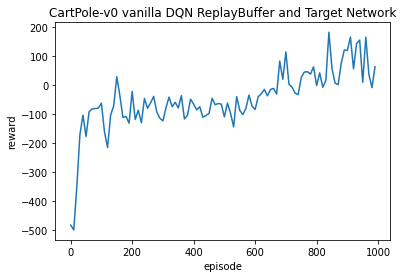

In [115]:
plt.figure()
plt.title("CartPole-v0 vanilla DQN ReplayBuffer and Target Network")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_3)
plt.show()

## Double DQN with Experience Replay Buffer and Target Network

https://arxiv.org/pdf/1509.06461v3.pdf

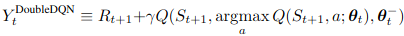

In [116]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-3
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1

tau = 1e-3 

In [117]:
replay_buffer = deque(maxlen=size_replay_buffer)
q_network = QNetwork(nb_actions,nb_observations)
q_target_network = QNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_4 = []
timestep = 0
average_list = deque(maxlen=100)

for episode in tqdm(range(nb_episode)) :
    
    state = env.reset()
    done = False
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        
        state_t = torch.as_tensor(state , dtype = torch.float32)
        
        if random.random() < epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0:
        
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)
            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64).unsqueeze(1)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32).unsqueeze(1)
            
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1)).detach()

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
            timestep += 1
        
        state = new_state
        
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_4.append(t)

  0%|                                          | 2/1000 [00:00<02:44,  6.05it/s]

episode 0 - test reward : -166.16601979483363 - avg : -119.64506814652248 - epsilon 0.995


  1%|▍                                        | 11/1000 [00:03<07:10,  2.30it/s]

episode 10 - test reward : -153.00794283281184 - avg : -186.93241230526547 - epsilon 0.946354579813443


  2%|▊                                        | 21/1000 [00:10<16:15,  1.00it/s]

episode 20 - test reward : -267.77684518586045 - avg : -223.5580008755465 - epsilon 0.9000874278732445


  3%|█▎                                       | 31/1000 [00:20<21:50,  1.35s/it]

episode 30 - test reward : -138.90466373212925 - avg : -210.1555057219561 - epsilon 0.8560822709551227


  4%|█▌                                     | 41/1000 [00:54<1:33:32,  5.85s/it]

episode 40 - test reward : -142.35235790850822 - avg : -202.08276234164356 - epsilon 0.8142285204175609


  5%|█▉                                     | 51/1000 [01:37<1:43:58,  6.57s/it]

episode 50 - test reward : -100.31585859619815 - avg : -178.86899622862617 - epsilon 0.7744209942832988


  6%|██▌                                      | 61/1000 [02:07<47:30,  3.04s/it]

episode 60 - test reward : -229.8001951356442 - avg : -167.42096568414902 - epsilon 0.736559652908221


  7%|██▉                                      | 71/1000 [02:21<19:06,  1.23s/it]

episode 70 - test reward : -161.92072982288127 - avg : -156.44011470971876 - epsilon 0.7005493475733617


  8%|███▎                                     | 81/1000 [02:30<18:48,  1.23s/it]

episode 80 - test reward : -149.1292448218732 - avg : -151.42178935735137 - epsilon 0.6662995813682115


  9%|███▋                                     | 91/1000 [02:48<45:19,  2.99s/it]

episode 90 - test reward : -126.77370108238952 - avg : -147.82168727319646 - epsilon 0.6337242817644086


 10%|████                                    | 101/1000 [02:58<11:48,  1.27it/s]

episode 100 - test reward : -92.3532431725267 - avg : -148.75934467966906 - epsilon 0.6027415843082742


 11%|████▍                                   | 111/1000 [03:06<27:32,  1.86s/it]

episode 110 - test reward : -133.75420003022447 - avg : -139.7937806814273 - epsilon 0.5732736268885887


 12%|████▊                                   | 121/1000 [03:21<33:11,  2.27s/it]

episode 120 - test reward : -91.44046311268455 - avg : -124.95357670426904 - epsilon 0.5452463540625918


 13%|█████▏                                  | 131/1000 [03:31<14:11,  1.02it/s]

episode 130 - test reward : -125.23772815438797 - avg : -115.96700033472217 - epsilon 0.5185893309484582


 14%|█████▋                                  | 141/1000 [03:46<41:43,  2.91s/it]

episode 140 - test reward : -97.71793243536483 - avg : -110.05369427225041 - epsilon 0.4932355662165453


 15%|██████                                  | 151/1000 [03:56<35:25,  2.50s/it]

episode 150 - test reward : -118.77988592812567 - avg : -108.75634934658085 - epsilon 0.46912134373457726


 16%|██████▍                                 | 161/1000 [04:10<49:01,  3.51s/it]

episode 160 - test reward : -87.50872495036126 - avg : -103.2784171540578 - epsilon 0.446186062443672


 17%|██████▊                                 | 171/1000 [04:18<26:27,  1.92s/it]

episode 170 - test reward : -88.55197142110958 - avg : -102.71527592910552 - epsilon 0.42437208406280985


 18%|███████▏                                | 181/1000 [04:33<43:57,  3.22s/it]

episode 180 - test reward : -91.79186814580399 - avg : -95.93288006577299 - epsilon 0.4036245882390106


 19%|███████▋                                | 191/1000 [04:49<57:14,  4.25s/it]

episode 190 - test reward : -75.85745016780643 - avg : -91.80743993786966 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [05:03<51:33,  3.87s/it]

episode 200 - test reward : -121.86923802650787 - avg : -82.7532202555326 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [05:15<40:43,  3.10s/it]

episode 210 - test reward : -81.40980689634975 - avg : -80.20782893512512 - epsilon 0.3472722151889232


 22%|████████▊                               | 221/1000 [05:32<46:48,  3.61s/it]

episode 220 - test reward : -96.6451107601466 - avg : -74.83128930219463 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [05:49<56:41,  4.42s/it]

episode 230 - test reward : -47.82449945255074 - avg : -72.42435068114786 - epsilon 0.3141460853680822


 24%|█████████▏                            | 241/1000 [06:07<1:04:54,  5.13s/it]

episode 240 - test reward : -43.650146566302354 - avg : -69.77699297403024 - epsilon 0.2987875242397482


 25%|██████████                              | 252/1000 [06:22<36:22,  2.92s/it]

episode 250 - test reward : -105.7043522458184 - avg : -69.15818138561023 - epsilon 0.28417984116121187


 26%|██████████▍                             | 261/1000 [06:36<47:16,  3.84s/it]

episode 260 - test reward : -71.86075538671359 - avg : -72.83846059721279 - epsilon 0.2702863258025825


 27%|██████████▉                             | 272/1000 [06:55<45:45,  3.77s/it]

episode 270 - test reward : -58.53702442561564 - avg : -75.19735682859191 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [07:07<36:40,  3.06s/it]

episode 280 - test reward : -82.70367392139683 - avg : -77.93226657992996 - epsilon 0.24450384299593592


 29%|███████████▋                            | 291/1000 [07:22<48:03,  4.07s/it]

episode 290 - test reward : -49.83874531856171 - avg : -78.67971423556824 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [07:38<52:02,  4.47s/it]

episode 300 - test reward : -109.01506924342065 - avg : -81.74525620227614 - epsilon 0.2211807388415433


 31%|████████████▍                           | 311/1000 [07:54<47:23,  4.13s/it]

episode 310 - test reward : -89.40355531663383 - avg : -83.4019138273978 - epsilon 0.21036724137609603


 32%|████████████▊                           | 321/1000 [08:09<43:45,  3.87s/it]

episode 320 - test reward : -79.16706665929067 - avg : -86.6969109396844 - epsilon 0.2000824143909432


 33%|█████████████▎                          | 332/1000 [08:15<10:26,  1.07it/s]

episode 330 - test reward : -230.23939835782465 - avg : -91.30964289860563 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 342/1000 [08:27<26:04,  2.38s/it]

episode 340 - test reward : -59.055773036326876 - avg : -90.79100515146104 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [08:37<26:53,  2.49s/it]

episode 350 - test reward : -234.18254990342513 - avg : -94.25715670732184 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 362/1000 [08:45<16:16,  1.53s/it]

episode 360 - test reward : -201.19282172417894 - avg : -96.11845428016397 - epsilon 0.16373146555890544


 37%|██████████████▊                         | 371/1000 [08:58<36:58,  3.53s/it]

episode 370 - test reward : -180.46376608062346 - avg : -95.16566763603937 - epsilon 0.1557266555690826


 38%|███████████████▏                        | 381/1000 [09:07<22:13,  2.15s/it]

episode 380 - test reward : -68.91604958754793 - avg : -100.56232663341008 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 391/1000 [09:12<08:31,  1.19it/s]

episode 390 - test reward : -181.99897746952263 - avg : -103.67097614551591 - epsilon 0.14087196468590776


 40%|████████████████                        | 402/1000 [09:18<10:03,  1.01s/it]

episode 400 - test reward : -137.88979330143712 - avg : -104.5912182725541 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [09:22<08:53,  1.10it/s]

episode 410 - test reward : -239.5714825828407 - avg : -106.41690309291111 - epsilon 0.12743425563174798


 42%|████████████████▉                       | 422/1000 [09:28<09:13,  1.04it/s]

episode 420 - test reward : -431.08506038390186 - avg : -108.09823175290643 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [09:38<24:54,  2.63s/it]

episode 430 - test reward : -63.11162471010482 - avg : -110.11280637640786 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [09:42<04:56,  1.88it/s]

episode 440 - test reward : -324.1334803772679 - avg : -114.88584762719998 - epsilon 0.10964241905397228


 45%|██████████████████                      | 452/1000 [09:49<11:40,  1.28s/it]

episode 450 - test reward : -284.310447032338 - avg : -119.35437826635129 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 461/1000 [09:54<09:14,  1.03s/it]

episode 460 - test reward : -380.9057094428628 - avg : -118.92861357554764 - epsilon 0.09918368135888474


 47%|██████████████████▉                     | 472/1000 [10:01<10:39,  1.21s/it]

episode 470 - test reward : -181.6354064912656 - avg : -125.93823775758835 - epsilon 0.0943346041173244


 48%|███████████████████▎                    | 482/1000 [10:06<06:25,  1.34it/s]

episode 480 - test reward : -206.30931650863016 - avg : -126.75095363461611 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [10:12<09:42,  1.15s/it]

episode 490 - test reward : -198.6000335391755 - avg : -127.00119260114201 - epsilon 0.08533607153708872


 50%|████████████████████                    | 501/1000 [10:16<05:13,  1.59it/s]

episode 500 - test reward : -226.15758054266294 - avg : -133.79810689088342 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 512/1000 [10:20<04:20,  1.87it/s]

episode 510 - test reward : -260.9026275215582 - avg : -133.99807745117783 - epsilon 0.07719590465791494


 52%|████████████████████▉                   | 522/1000 [10:24<04:42,  1.69it/s]

episode 520 - test reward : -202.21864711778625 - avg : -134.67632036127617 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [10:27<03:40,  2.12it/s]

episode 530 - test reward : -268.8366930856712 - avg : -134.878924154696 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [10:32<09:01,  1.18s/it]

episode 540 - test reward : -115.10102234404785 - avg : -133.17669158405147 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 551/1000 [10:36<04:35,  1.63it/s]

episode 550 - test reward : -237.00305673385657 - avg : -136.41745570573997 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 562/1000 [10:40<03:02,  2.39it/s]

episode 560 - test reward : -247.33123353903594 - avg : -136.75709993934836 - epsilon 0.06008254194952879


 57%|██████████████████████▉                 | 572/1000 [10:48<09:35,  1.35s/it]

episode 570 - test reward : -114.14255683527225 - avg : -131.49653816608668 - epsilon 0.05714511431233153


 58%|███████████████████████▏                | 581/1000 [10:51<03:50,  1.82it/s]

episode 580 - test reward : -241.2872988368405 - avg : -131.08287197191538 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [10:56<06:46,  1.01it/s]

episode 590 - test reward : -279.612183235673 - avg : -133.13612813775944 - epsilon 0.05169406930342616


 60%|████████████████████████                | 602/1000 [11:01<05:08,  1.29it/s]

episode 600 - test reward : -215.44517212967042 - avg : -132.4317724732506 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [11:04<03:12,  2.03it/s]

episode 610 - test reward : -223.682091900953 - avg : -133.6018666018201 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [11:11<10:45,  1.70s/it]

episode 620 - test reward : -125.46204895638388 - avg : -135.79160229620663 - epsilon 0.04447676004441063


 63%|█████████████████████████▎              | 632/1000 [11:24<09:22,  1.53s/it]

episode 630 - test reward : -215.8195538007595 - avg : -134.20675169522835 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 641/1000 [11:33<14:32,  2.43s/it]

episode 640 - test reward : -25.666044830918416 - avg : -136.90922847537541 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 651/1000 [11:39<07:56,  1.37s/it]

episode 650 - test reward : -133.5602186685814 - avg : -134.5203932489849 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 661/1000 [11:50<14:43,  2.61s/it]

episode 660 - test reward : -94.13259549008708 - avg : -140.55342358775965 - epsilon 0.036396227662238566


 67%|██████████████████████████▉             | 672/1000 [11:57<06:36,  1.21s/it]

episode 670 - test reward : -125.73168722134528 - avg : -145.62166351096508 - epsilon 0.03461682084029365


 68%|███████████████████████████▎            | 682/1000 [12:07<07:44,  1.46s/it]

episode 680 - test reward : -129.62298368761617 - avg : -147.8631525962677 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [12:13<07:53,  1.53s/it]

episode 690 - test reward : -250.34947707797318 - avg : -148.7027755581529 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [12:17<03:44,  1.33it/s]

episode 700 - test reward : -270.7770866687671 - avg : -143.43286848807273 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [12:22<04:37,  1.04it/s]

episode 710 - test reward : -158.28129013138545 - avg : -144.6307735318303 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [12:28<05:12,  1.12s/it]

episode 720 - test reward : -151.41516719860272 - avg : -147.86567934167192 - epsilon 0.02694270634579598


 73%|█████████████████████████████▎          | 732/1000 [12:32<02:27,  1.82it/s]

episode 730 - test reward : -261.88703009378384 - avg : -152.77614814414852 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 741/1000 [12:41<10:23,  2.41s/it]

episode 740 - test reward : -154.9840765632405 - avg : -154.64145369078312 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [12:51<11:02,  2.66s/it]

episode 750 - test reward : -11.018557072208756 - avg : -155.1544477020392 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [13:02<11:01,  2.77s/it]

episode 760 - test reward : -92.74574452250094 - avg : -157.98081535001012 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [13:14<11:59,  3.14s/it]

episode 770 - test reward : 6.7754341864873115 - avg : -159.14568031821887 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [13:22<06:47,  1.86s/it]

episode 780 - test reward : -201.52128036837766 - avg : -159.01874556226588 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [13:27<03:54,  1.12s/it]

episode 790 - test reward : -242.8078217001058 - avg : -161.01520568607776 - epsilon 0.02


 80%|████████████████████████████████        | 801/1000 [13:40<10:22,  3.13s/it]

episode 800 - test reward : -73.56790258784119 - avg : -168.60521030870026 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [13:48<06:53,  2.19s/it]

episode 810 - test reward : -17.242623403820456 - avg : -172.10583540036075 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [13:57<06:44,  2.26s/it]

episode 820 - test reward : -150.41828818883565 - avg : -171.32017672554335 - epsilon 0.02


 83%|█████████████████████████████████▎      | 832/1000 [14:04<03:26,  1.23s/it]

episode 830 - test reward : -190.95618562540088 - avg : -169.3335436936109 - epsilon 0.02


 84%|█████████████████████████████████▋      | 842/1000 [14:09<01:58,  1.34it/s]

episode 840 - test reward : -207.87629666392837 - avg : -167.2460978306191 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [14:24<10:24,  4.19s/it]

episode 850 - test reward : -79.19261161979172 - avg : -173.7079369592899 - epsilon 0.02


 86%|██████████████████████████████████▍     | 861/1000 [14:40<09:55,  4.28s/it]

episode 860 - test reward : -48.21449606146226 - avg : -169.90777554407794 - epsilon 0.02


 87%|██████████████████████████████████▊     | 871/1000 [14:52<06:54,  3.21s/it]

episode 870 - test reward : -97.94616704278687 - avg : -168.16487713195133 - epsilon 0.02


 88%|███████████████████████████████████▎    | 882/1000 [15:08<06:08,  3.12s/it]

episode 880 - test reward : -69.93309773410974 - avg : -168.53547368071384 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [15:16<03:40,  2.02s/it]

episode 890 - test reward : -20.553959514085058 - avg : -164.3516320079737 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [15:29<05:44,  3.48s/it]

episode 900 - test reward : -76.55524013751801 - avg : -160.62933564081652 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [15:35<02:06,  1.42s/it]

episode 910 - test reward : -0.7030942875937427 - avg : -161.33337487533097 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [15:43<02:28,  1.88s/it]

episode 920 - test reward : -34.90340345863166 - avg : -160.3771475250503 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [15:59<04:54,  4.27s/it]

episode 930 - test reward : -72.50128182120315 - avg : -169.4731864013037 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [16:10<02:46,  2.83s/it]

episode 940 - test reward : -156.89196884421722 - avg : -175.842258736521 - epsilon 0.02


 95%|██████████████████████████████████████  | 952/1000 [16:14<00:27,  1.72it/s]

episode 950 - test reward : -163.49627526484045 - avg : -165.4205014101179 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [16:23<01:23,  2.14s/it]

episode 960 - test reward : -134.81732800426582 - avg : -162.92756500890343 - epsilon 0.02


 97%|██████████████████████████████████████▉ | 972/1000 [16:32<00:46,  1.65s/it]

episode 970 - test reward : -129.50503515543852 - avg : -166.35745760613474 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [16:38<00:25,  1.37s/it]

episode 980 - test reward : -91.99321234584957 - avg : -167.24412707621502 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [16:55<00:40,  4.55s/it]

episode 990 - test reward : -46.781608541776215 - avg : -172.4966188341537 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [16:57<00:00,  1.02s/it]


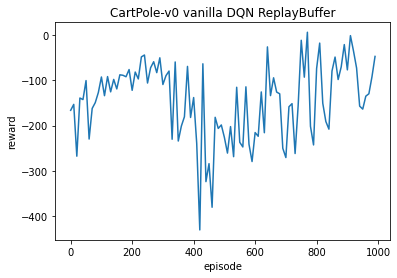

In [118]:
plt.figure()
plt.title("CartPole-v0 vanilla DQN ReplayBuffer")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_4)
plt.show()

## Dueling DQN with Experience Replay Buffer and Target Network

source : https://arxiv.org/pdf/1511.06581.pdf

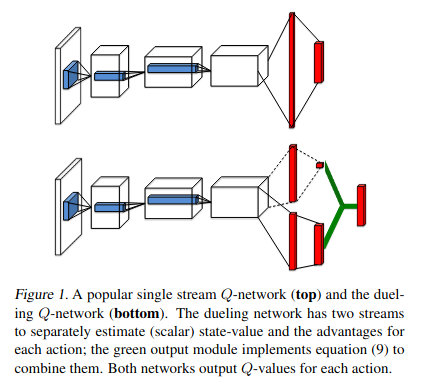

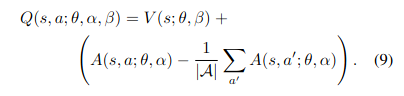

In [119]:
def test(q_network) :
    
    state = env.reset()
    done = False
    cum_sum = 0
    while not done :
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        action = torch.argmax(q_network(state_t)).item()
        new_state,reward,done,_ = env.step(action)
        state = new_state
        cum_sum += reward
        
    return cum_sum

In [120]:
class DuelingQNetwork(nn.Module) :
    
    def __init__(self,
              nb_actions,
              nb_observations) : 
        
        super().__init__()
        self.nb_actions = nb_actions
        self.nb_observations = nb_observations
        
        self.net = nn.Sequential(
            nn.Linear(nb_observations,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,32)
        )
        
        self.net_advantage = nn.Sequential(
            nn.ReLU(),
            nn.Linear(32,nb_actions)
        )
        
        self.net_state_value = nn.Sequential(
            nn.ReLU(),
            nn.Linear(32,1)
        )
        
    def advantage(self,x) :
        return self.net_advantage(self.net(x))
    
    def state_value(self,x) :
        return self.net_state_value(self.net(x))
    
    def forward(self,x) :
        return self.state_value(x) + self.advantage(x) - torch.mean(self.advantage(x),dim=1).unsqueeze(1)

In [121]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-3
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1
tau = 1e-3 

In [122]:
replay_buffer = deque(maxlen=size_replay_buffer)
q_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_5 = []
timestep = 0

average_list = deque(maxlen=100)


for episode in tqdm(range(nb_episode)) :
    state = env.reset()
    done = False
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        
        if random.random() < epsilon :
            action = torch.argmax(q_target_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
            
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)

            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32)
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.max(q_target_network(new_states_t),dim=1)[0].detach()

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
        timestep += 1
        
        state = new_state
        
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_5.append(t)

  0%|                                          | 1/1000 [00:00<06:12,  2.68it/s]

episode 0 - test reward : -143.83509916834322 - avg : -571.03423132268 - epsilon 0.995


  1%|▍                                        | 11/1000 [00:07<17:27,  1.06s/it]

episode 10 - test reward : -107.68510817683368 - avg : -318.9153027537213 - epsilon 0.946354579813443


  2%|▊                                        | 21/1000 [00:13<14:40,  1.11it/s]

episode 20 - test reward : -145.79427276383765 - avg : -197.80667499009533 - epsilon 0.9000874278732445


  3%|█▎                                       | 31/1000 [00:29<28:30,  1.77s/it]

episode 30 - test reward : -279.6105413460901 - avg : -186.586120381935 - epsilon 0.8560822709551227


  4%|█▌                                     | 41/1000 [01:07<1:48:01,  6.76s/it]

episode 40 - test reward : -124.60672277419462 - avg : -171.66866167008635 - epsilon 0.8142285204175609


  5%|█▉                                     | 51/1000 [01:57<2:06:43,  8.01s/it]

episode 50 - test reward : -76.60723892531068 - avg : -146.29429606083673 - epsilon 0.7744209942832988


  6%|██▍                                    | 61/1000 [02:47<1:33:45,  5.99s/it]

episode 60 - test reward : -41.76399424771385 - avg : -129.51827550651961 - epsilon 0.736559652908221


  7%|██▊                                    | 71/1000 [03:22<1:12:35,  4.69s/it]

episode 70 - test reward : -37.014464460868474 - avg : -115.66694536595065 - epsilon 0.7005493475733617


  8%|███▎                                     | 81/1000 [03:37<16:20,  1.07s/it]

episode 80 - test reward : -69.94256546945574 - avg : -107.23779621474668 - epsilon 0.6662995813682115


  9%|███▋                                     | 91/1000 [04:01<48:59,  3.23s/it]

episode 90 - test reward : 19.57196012532587 - avg : -101.8406369174357 - epsilon 0.6337242817644086


 10%|████                                    | 101/1000 [04:22<48:16,  3.22s/it]

episode 100 - test reward : 78.17592469465748 - avg : -89.62502117818869 - epsilon 0.6027415843082742


 11%|████▍                                   | 111/1000 [04:30<17:07,  1.16s/it]

episode 110 - test reward : -81.21190272307766 - avg : -63.217500447289865 - epsilon 0.5732736268885887


 12%|████▊                                   | 121/1000 [04:36<12:56,  1.13it/s]

episode 120 - test reward : 65.42907266901935 - avg : -63.88211351625991 - epsilon 0.5452463540625918


 13%|█████▏                                  | 131/1000 [04:49<17:26,  1.20s/it]

episode 130 - test reward : -0.716077087200631 - avg : -52.25398517237076 - epsilon 0.5185893309484582


 14%|█████▋                                  | 141/1000 [05:01<25:11,  1.76s/it]

episode 140 - test reward : -146.5164934668758 - avg : -42.21273379622092 - epsilon 0.4932355662165453


 15%|██████                                  | 151/1000 [05:11<15:04,  1.07s/it]

episode 150 - test reward : -70.35775019654572 - avg : -43.23171864753294 - epsilon 0.46912134373457726


 16%|██████▍                                 | 161/1000 [05:18<18:35,  1.33s/it]

episode 160 - test reward : 48.7416093736374 - avg : -44.10030166865854 - epsilon 0.446186062443672


 17%|██████▊                                 | 171/1000 [05:24<16:31,  1.20s/it]

episode 170 - test reward : 58.09212037908751 - avg : -46.68972811433055 - epsilon 0.42437208406280985


 18%|███████▏                                | 181/1000 [05:33<23:19,  1.71s/it]

episode 180 - test reward : -9.08292824474829 - avg : -47.286822917381194 - epsilon 0.4036245882390106


 19%|███████▋                                | 191/1000 [05:43<33:29,  2.48s/it]

episode 190 - test reward : 9.227845630557805 - avg : -45.187415619212395 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [05:52<24:50,  1.87s/it]

episode 200 - test reward : 46.46037935755836 - avg : -52.48951483598725 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [06:01<25:27,  1.94s/it]

episode 210 - test reward : 72.34921451479717 - avg : -55.55828600743489 - epsilon 0.3472722151889232


 22%|████████▊                               | 221/1000 [06:12<32:49,  2.53s/it]

episode 220 - test reward : 13.5900886886182 - avg : -56.72947897110885 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [06:19<14:28,  1.13s/it]

episode 230 - test reward : 47.92613767010624 - avg : -59.71216759474181 - epsilon 0.3141460853680822


 24%|█████████▋                              | 241/1000 [06:23<07:48,  1.62it/s]

episode 240 - test reward : -62.70120594842501 - avg : -63.97453732219015 - epsilon 0.2987875242397482


 25%|██████████                              | 251/1000 [06:37<39:53,  3.20s/it]

episode 250 - test reward : -27.247597188489912 - avg : -64.82776989144934 - epsilon 0.28417984116121187


 26%|██████████▍                             | 261/1000 [06:45<20:48,  1.69s/it]

episode 260 - test reward : -50.76766928857164 - avg : -72.96248497785591 - epsilon 0.2702863258025825


 27%|██████████▊                             | 271/1000 [06:55<14:52,  1.22s/it]

episode 270 - test reward : -184.91228964451247 - avg : -75.40713711942517 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [07:05<15:01,  1.25s/it]

episode 280 - test reward : -80.78258726339723 - avg : -77.99241307725438 - epsilon 0.24450384299593592


 29%|███████████▋                            | 291/1000 [07:11<11:53,  1.01s/it]

episode 290 - test reward : -130.66874236634246 - avg : -81.38157279799266 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [07:17<12:32,  1.08s/it]

episode 300 - test reward : -96.28306274662745 - avg : -79.10098748028354 - epsilon 0.2211807388415433


 31%|████████████▍                           | 311/1000 [07:24<15:11,  1.32s/it]

episode 310 - test reward : -190.09827740194754 - avg : -81.63807592326314 - epsilon 0.21036724137609603


 32%|████████████▊                           | 321/1000 [07:33<22:19,  1.97s/it]

episode 320 - test reward : -133.69487262062665 - avg : -82.68550566775417 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [07:40<16:34,  1.49s/it]

episode 330 - test reward : -112.56337931881421 - avg : -82.26701930728429 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 341/1000 [07:45<08:38,  1.27it/s]

episode 340 - test reward : -203.9453882657254 - avg : -85.80493498467013 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [07:59<36:00,  3.33s/it]

episode 350 - test reward : -130.99349859805255 - avg : -90.8905533714061 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 361/1000 [08:05<12:31,  1.18s/it]

episode 360 - test reward : -99.40068682655364 - avg : -87.27168417616024 - epsilon 0.16373146555890544


 37%|██████████████▊                         | 371/1000 [08:15<24:16,  2.32s/it]

episode 370 - test reward : -174.2885738996786 - avg : -87.40860223458778 - epsilon 0.1557266555690826


 38%|███████████████▏                        | 381/1000 [08:23<17:37,  1.71s/it]

episode 380 - test reward : -103.8867208151685 - avg : -90.94341536397354 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 391/1000 [08:31<17:24,  1.72s/it]

episode 390 - test reward : -200.879253459444 - avg : -94.93062391728091 - epsilon 0.14087196468590776


 40%|████████████████                        | 401/1000 [08:40<17:06,  1.71s/it]

episode 400 - test reward : -93.94102801811951 - avg : -99.88368414211976 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [08:47<13:32,  1.38s/it]

episode 410 - test reward : -130.257197757149 - avg : -105.4277709183687 - epsilon 0.12743425563174798


 42%|████████████████▊                       | 421/1000 [08:54<15:11,  1.57s/it]

episode 420 - test reward : -142.8568073807218 - avg : -113.227676252446 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [09:01<12:58,  1.37s/it]

episode 430 - test reward : -161.89064020675795 - avg : -114.5037106327924 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [09:09<15:21,  1.65s/it]

episode 440 - test reward : -121.77200913386953 - avg : -114.89175242132723 - epsilon 0.10964241905397228


 45%|██████████████████                      | 451/1000 [09:17<15:17,  1.67s/it]

episode 450 - test reward : -82.94067460667563 - avg : -112.23151988794494 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 461/1000 [09:23<08:18,  1.08it/s]

episode 460 - test reward : -38.43735522237357 - avg : -118.676583751628 - epsilon 0.09918368135888474


 47%|██████████████████▊                     | 471/1000 [09:28<07:03,  1.25it/s]

episode 470 - test reward : -132.47353415781535 - avg : -123.16864294925304 - epsilon 0.0943346041173244


 48%|███████████████████▏                    | 481/1000 [09:35<11:49,  1.37s/it]

episode 480 - test reward : -98.72588618874923 - avg : -121.6468314991278 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [09:42<11:06,  1.31s/it]

episode 490 - test reward : -133.01851313572428 - avg : -122.37315840013312 - epsilon 0.08533607153708872


 50%|████████████████████                    | 501/1000 [09:47<06:25,  1.30it/s]

episode 500 - test reward : -170.16135444193722 - avg : -123.14711103471909 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 511/1000 [09:53<08:07,  1.00it/s]

episode 510 - test reward : -92.08375374336477 - avg : -126.52372576496178 - epsilon 0.07719590465791494


 52%|████████████████████▊                   | 521/1000 [09:59<08:39,  1.08s/it]

episode 520 - test reward : -155.34064141921272 - avg : -122.6099236199102 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [10:06<10:25,  1.33s/it]

episode 530 - test reward : -143.0624891996186 - avg : -126.38923165739027 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [10:12<09:06,  1.19s/it]

episode 540 - test reward : -56.244407681287306 - avg : -133.34709020865338 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 551/1000 [10:18<08:05,  1.08s/it]

episode 550 - test reward : -187.4167330225748 - avg : -137.2667973744699 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [10:25<08:26,  1.15s/it]

episode 560 - test reward : -111.5506923512401 - avg : -139.0953687434471 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [10:31<07:53,  1.10s/it]

episode 570 - test reward : -180.94873954630452 - avg : -140.38737052386247 - epsilon 0.05714511431233153


 58%|███████████████████████▏                | 581/1000 [10:38<09:18,  1.33s/it]

episode 580 - test reward : -168.05047137899766 - avg : -144.0267469591738 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [10:44<08:10,  1.20s/it]

episode 590 - test reward : -81.03130827102059 - avg : -147.0162865989122 - epsilon 0.05169406930342616


 60%|████████████████████████                | 601/1000 [10:50<06:09,  1.08it/s]

episode 600 - test reward : -108.7939987971794 - avg : -143.11595800342258 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [10:57<10:48,  1.67s/it]

episode 610 - test reward : -89.72597363692311 - avg : -144.4322482632559 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [11:05<09:17,  1.47s/it]

episode 620 - test reward : -110.95798509231831 - avg : -148.47697158152815 - epsilon 0.04447676004441063


 63%|█████████████████████████▏              | 631/1000 [11:12<08:57,  1.46s/it]

episode 630 - test reward : -83.08819176402002 - avg : -152.71845075935295 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 641/1000 [11:19<06:03,  1.01s/it]

episode 640 - test reward : -186.6873734966218 - avg : -155.493518420477 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 651/1000 [11:25<06:18,  1.08s/it]

episode 650 - test reward : -79.25452423655875 - avg : -158.0965827368524 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 661/1000 [11:31<05:36,  1.01it/s]

episode 660 - test reward : -288.8470388054327 - avg : -153.57910722266533 - epsilon 0.036396227662238566


 67%|██████████████████████████▊             | 671/1000 [11:36<05:22,  1.02it/s]

episode 670 - test reward : -28.304855488538085 - avg : -155.62223415143214 - epsilon 0.03461682084029365


 68%|███████████████████████████▏            | 681/1000 [11:44<08:31,  1.60s/it]

episode 680 - test reward : -52.141204367263626 - avg : -155.2084465685906 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [11:51<06:04,  1.18s/it]

episode 690 - test reward : -119.33420650783746 - avg : -155.76863101904237 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [11:57<06:24,  1.29s/it]

episode 700 - test reward : -14.013373110330415 - avg : -159.89318144640566 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [12:05<07:38,  1.59s/it]

episode 710 - test reward : -114.85436205931748 - avg : -154.89191388161873 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [12:11<05:08,  1.10s/it]

episode 720 - test reward : -150.26018686405507 - avg : -155.6503890523181 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [12:16<03:37,  1.24it/s]

episode 730 - test reward : -155.74372173139304 - avg : -153.43085905884436 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 741/1000 [12:22<04:46,  1.11s/it]

episode 740 - test reward : -90.73285585799324 - avg : -144.19856205077753 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [12:30<06:22,  1.53s/it]

episode 750 - test reward : -2.959790106853737 - avg : -142.85749520789696 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [12:35<03:25,  1.16it/s]

episode 760 - test reward : -220.40020425423063 - avg : -147.4752890306048 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [12:39<02:56,  1.30it/s]

episode 770 - test reward : -183.9589099884284 - avg : -144.00561864624464 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [12:46<04:38,  1.27s/it]

episode 780 - test reward : -85.22253781123683 - avg : -147.75346590002923 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [12:52<04:02,  1.16s/it]

episode 790 - test reward : -222.10832669429902 - avg : -152.6135401257134 - epsilon 0.02


 80%|████████████████████████████████        | 801/1000 [13:00<05:14,  1.58s/it]

episode 800 - test reward : -138.43889734193107 - avg : -157.08766151787572 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [13:06<03:41,  1.17s/it]

episode 810 - test reward : -142.857459173127 - avg : -157.7088892020957 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [13:13<03:41,  1.24s/it]

episode 820 - test reward : -194.23763459609913 - avg : -153.83491259733637 - epsilon 0.02


 83%|█████████████████████████████████▏      | 831/1000 [13:18<02:38,  1.07it/s]

episode 830 - test reward : -159.8667076720696 - avg : -155.4185589168339 - epsilon 0.02


 84%|█████████████████████████████████▋      | 841/1000 [13:26<03:41,  1.39s/it]

episode 840 - test reward : -118.70636941329806 - avg : -161.5801561519845 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [13:31<02:09,  1.15it/s]

episode 850 - test reward : -204.4933768062751 - avg : -162.94672486605566 - epsilon 0.02


 86%|██████████████████████████████████▍     | 861/1000 [13:41<05:20,  2.31s/it]

episode 860 - test reward : -224.90327940180455 - avg : -161.80772203449763 - epsilon 0.02


 87%|██████████████████████████████████▊     | 871/1000 [13:48<02:53,  1.34s/it]

episode 870 - test reward : -243.00247833883532 - avg : -164.8749559707881 - epsilon 0.02


 88%|███████████████████████████████████▏    | 881/1000 [13:54<02:25,  1.22s/it]

episode 880 - test reward : -69.19666189079953 - avg : -162.82686251499504 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [14:00<01:45,  1.03it/s]

episode 890 - test reward : -174.83159931497934 - avg : -161.38938026442452 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [14:08<02:56,  1.79s/it]

episode 900 - test reward : -136.81826232426047 - avg : -157.74317262489 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [14:21<04:42,  3.18s/it]

episode 910 - test reward : -74.52694018639511 - avg : -164.35530920304765 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [14:26<01:16,  1.03it/s]

episode 920 - test reward : -145.21249826636114 - avg : -170.69282666880233 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [14:37<02:49,  2.46s/it]

episode 930 - test reward : -201.7317170958758 - avg : -172.40693114384686 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [14:45<01:35,  1.62s/it]

episode 940 - test reward : -317.053556249033 - avg : -172.08857932508832 - epsilon 0.02


 95%|██████████████████████████████████████  | 951/1000 [14:51<00:53,  1.10s/it]

episode 950 - test reward : -419.55746597962553 - avg : -176.17225744630187 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [14:58<00:50,  1.30s/it]

episode 960 - test reward : -384.4211552760763 - avg : -180.82600799864832 - epsilon 0.02


 97%|██████████████████████████████████████▊ | 971/1000 [15:05<00:35,  1.21s/it]

episode 970 - test reward : -297.70601619582646 - avg : -182.977660060909 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [15:15<00:27,  1.44s/it]

episode 980 - test reward : -282.25704806129187 - avg : -181.80354015235332 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [15:23<00:16,  1.82s/it]

episode 990 - test reward : -181.39692865943886 - avg : -180.77656323319704 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [15:26<00:00,  1.08it/s]


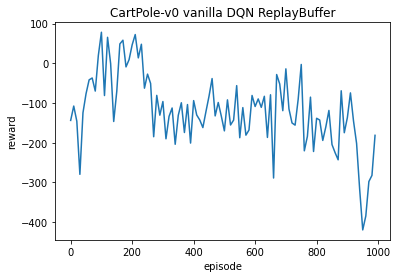

In [123]:
plt.figure()
plt.title("CartPole-v0 vanilla DQN ReplayBuffer")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_5)
plt.show()

## Dueling Double DQN with Experience Replay Buffer and Target Network (D3QN)

In [124]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-3
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1
tau = 1e-3 

In [125]:
replay_buffer = deque(maxlen=size_replay_buffer)
q_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_6 = []
timestep = 0

average_list = deque(maxlen=100)

for episode in tqdm(range(nb_episode)) :
    state = env.reset()
    done = False
    
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        
        if random.random() < epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)

        cumul += reward
        
        transition = (state,action,done,reward,new_state)
        replay_buffer.append(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
        
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            dones = np.asarray([exp[2] for exp in batch],dtype=int)
            rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)
            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64).unsqueeze(1)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32).unsqueeze(1)
            
            
            y_target = rewards_t + discount_factor * (1 - dones_t) * torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1)).detach()

            mse = nn.MSELoss()

            loss = mse(torch.gather(q_network(states_t),dim=1,index=actions_t), y_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
        timestep += 1
        
        state = new_state
        
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_6.append(t)

  0%|                                          | 1/1000 [00:00<06:45,  2.46it/s]

episode 0 - test reward : -507.68577085750286 - avg : -518.2916793784624 - epsilon 0.995


  1%|▍                                        | 11/1000 [00:06<13:24,  1.23it/s]

episode 10 - test reward : -248.01536414719368 - avg : -262.914264122325 - epsilon 0.946354579813443


  2%|▊                                        | 21/1000 [00:14<16:35,  1.02s/it]

episode 20 - test reward : -274.07941495978883 - avg : -281.4709465940977 - epsilon 0.9000874278732445


  3%|█▎                                       | 31/1000 [00:37<30:26,  1.89s/it]

episode 30 - test reward : -262.3198484528872 - avg : -256.3928183153436 - epsilon 0.8560822709551227


  4%|█▋                                       | 41/1000 [00:51<36:34,  2.29s/it]

episode 40 - test reward : -120.70163559918576 - avg : -225.47411072922776 - epsilon 0.8142285204175609


  5%|██                                       | 51/1000 [01:08<46:58,  2.97s/it]

episode 50 - test reward : -187.85669336331907 - avg : -227.50732169876798 - epsilon 0.7744209942832988


  6%|██▌                                      | 61/1000 [01:32<48:01,  3.07s/it]

episode 60 - test reward : -282.2624202535834 - avg : -211.19067212366707 - epsilon 0.736559652908221


  7%|██▊                                    | 71/1000 [02:27<2:05:53,  8.13s/it]

episode 70 - test reward : -30.606483807597833 - avg : -191.4869646938667 - epsilon 0.7005493475733617


  8%|███▏                                   | 81/1000 [03:19<1:54:51,  7.50s/it]

episode 80 - test reward : -110.26997082164408 - avg : -169.3071714806014 - epsilon 0.6662995813682115


  9%|███▋                                     | 91/1000 [03:50<46:56,  3.10s/it]

episode 90 - test reward : -89.45156518026684 - avg : -154.04824002137335 - epsilon 0.6337242817644086


 10%|████                                    | 101/1000 [04:11<30:53,  2.06s/it]

episode 100 - test reward : 30.27264296382315 - avg : -141.59464294137308 - epsilon 0.6027415843082742


 11%|████▍                                   | 111/1000 [04:23<17:04,  1.15s/it]

episode 110 - test reward : -106.20272933365497 - avg : -119.53568069911299 - epsilon 0.5732736268885887


 12%|████▊                                   | 121/1000 [04:29<13:59,  1.05it/s]

episode 120 - test reward : 20.51953792798539 - avg : -96.98947117349495 - epsilon 0.5452463540625918


 13%|█████▏                                  | 131/1000 [04:35<11:22,  1.27it/s]

episode 130 - test reward : 17.061527109399815 - avg : -83.94589674791114 - epsilon 0.5185893309484582


 14%|█████▋                                  | 141/1000 [04:44<24:11,  1.69s/it]

episode 140 - test reward : 13.468830623961367 - avg : -76.70601187877634 - epsilon 0.4932355662165453


 15%|██████                                  | 151/1000 [04:50<14:37,  1.03s/it]

episode 150 - test reward : 70.49791886143595 - avg : -60.823510498922516 - epsilon 0.46912134373457726


 16%|██████▍                                 | 161/1000 [04:57<14:02,  1.00s/it]

episode 160 - test reward : 8.030075164375011 - avg : -54.20686232522638 - epsilon 0.446186062443672


 17%|██████▊                                 | 171/1000 [05:08<22:01,  1.59s/it]

episode 170 - test reward : -17.143973774360585 - avg : -54.54182745536692 - epsilon 0.42437208406280985


 18%|███████▏                                | 181/1000 [05:17<24:31,  1.80s/it]

episode 180 - test reward : -42.165249712455505 - avg : -60.13801183941885 - epsilon 0.4036245882390106


 19%|███████▋                                | 191/1000 [05:26<23:11,  1.72s/it]

episode 190 - test reward : 38.359229421046194 - avg : -62.63521518235797 - epsilon 0.38389143477919885


 20%|████████                                | 201/1000 [05:36<29:51,  2.24s/it]

episode 200 - test reward : 149.17172365658047 - avg : -61.316658226433894 - epsilon 0.36512303261753626


 21%|████████▍                               | 211/1000 [05:44<21:20,  1.62s/it]

episode 210 - test reward : 85.52598693375867 - avg : -68.90905189133554 - epsilon 0.3472722151889232


 22%|████████▊                               | 221/1000 [05:50<12:03,  1.08it/s]

episode 220 - test reward : 220.96735621652297 - avg : -69.20769141624534 - epsilon 0.3302941218954743


 23%|█████████▏                              | 231/1000 [05:57<14:23,  1.12s/it]

episode 230 - test reward : 155.7122309061811 - avg : -69.29858824985281 - epsilon 0.3141460853680822


 24%|█████████▋                              | 241/1000 [06:08<30:31,  2.41s/it]

episode 240 - test reward : 158.53173307013572 - avg : -70.20624110409598 - epsilon 0.2987875242397482


 25%|██████████                              | 251/1000 [06:15<16:41,  1.34s/it]

episode 250 - test reward : 229.44139022976643 - avg : -71.17753409230995 - epsilon 0.28417984116121187


 26%|██████████▍                             | 261/1000 [06:23<21:13,  1.72s/it]

episode 260 - test reward : 180.4949004171551 - avg : -72.79799017220566 - epsilon 0.2702863258025825


 27%|██████████▊                             | 271/1000 [06:30<14:06,  1.16s/it]

episode 270 - test reward : 116.61196996145593 - avg : -74.55455275276333 - epsilon 0.2570720625972084


 28%|███████████▏                            | 281/1000 [06:37<13:13,  1.10s/it]

episode 280 - test reward : 85.35140233169399 - avg : -78.11098203092025 - epsilon 0.24450384299593592


 29%|███████████▋                            | 291/1000 [06:44<14:00,  1.19s/it]

episode 290 - test reward : 101.10167327881432 - avg : -82.1842772237052 - epsilon 0.23255008201124722


 30%|████████████                            | 301/1000 [06:52<16:50,  1.45s/it]

episode 300 - test reward : 158.68117368960318 - avg : -89.06164812282584 - epsilon 0.2211807388415433


 31%|████████████▍                           | 311/1000 [06:59<13:34,  1.18s/it]

episode 310 - test reward : 50.5103379434659 - avg : -89.91086988507978 - epsilon 0.21036724137609603


 32%|████████████▊                           | 321/1000 [07:09<24:16,  2.14s/it]

episode 320 - test reward : 176.293632941756 - avg : -90.97756600198073 - epsilon 0.2000824143909432


 33%|█████████████▏                          | 331/1000 [07:20<27:40,  2.48s/it]

episode 330 - test reward : 124.95304311248671 - avg : -92.58560773603598 - epsilon 0.1903004112552766


 34%|█████████████▋                          | 341/1000 [07:33<32:27,  2.96s/it]

episode 340 - test reward : 43.71776868028043 - avg : -96.1305840153578 - epsilon 0.18099664897669618


 35%|██████████████                          | 351/1000 [07:45<32:04,  2.97s/it]

episode 350 - test reward : 107.12232262456992 - avg : -96.72583879302353 - epsilon 0.17214774642209296


 36%|██████████████▍                         | 361/1000 [07:54<19:05,  1.79s/it]

episode 360 - test reward : 43.18718687150815 - avg : -101.15258084091771 - epsilon 0.16373146555890544


 37%|██████████████▊                         | 371/1000 [08:06<28:19,  2.70s/it]

episode 370 - test reward : 67.7952693885204 - avg : -102.98083758325265 - epsilon 0.1557266555690826


 38%|███████████████▏                        | 381/1000 [08:17<27:27,  2.66s/it]

episode 380 - test reward : 117.39986439694914 - avg : -107.8254205512832 - epsilon 0.14811319969530845


 39%|███████████████▋                        | 391/1000 [08:24<13:59,  1.38s/it]

episode 390 - test reward : 87.51510193480928 - avg : -107.20175008541834 - epsilon 0.14087196468590776


 40%|████████████████                        | 401/1000 [08:37<28:40,  2.87s/it]

episode 400 - test reward : 67.17842563994148 - avg : -104.29399091103059 - epsilon 0.13398475271138335


 41%|████████████████▍                       | 411/1000 [08:44<13:51,  1.41s/it]

episode 410 - test reward : 107.23146383325452 - avg : -107.06973023414821 - epsilon 0.12743425563174798


 42%|████████████████▊                       | 421/1000 [08:51<13:39,  1.42s/it]

episode 420 - test reward : 77.80702097560405 - avg : -112.8452608812771 - epsilon 0.12120401149972035


 43%|█████████████████▏                      | 431/1000 [08:59<14:25,  1.52s/it]

episode 430 - test reward : 98.05966408357709 - avg : -116.40065301208868 - epsilon 0.11527836319047392


 44%|█████████████████▋                      | 441/1000 [09:15<36:21,  3.90s/it]

episode 440 - test reward : 73.36834440196621 - avg : -121.35559704999378 - epsilon 0.10964241905397228


 45%|██████████████████                      | 451/1000 [09:25<20:04,  2.19s/it]

episode 450 - test reward : 170.88868634360958 - avg : -124.9392224963333 - epsilon 0.1042820154910064


 46%|██████████████████▍                     | 461/1000 [09:35<17:26,  1.94s/it]

episode 460 - test reward : 88.78028837341503 - avg : -126.93423009603055 - epsilon 0.09918368135888474


 47%|██████████████████▊                     | 471/1000 [09:51<36:15,  4.11s/it]

episode 470 - test reward : 3.0517375704521412 - avg : -132.78102063903978 - epsilon 0.0943346041173244


 48%|███████████████████▏                    | 481/1000 [10:03<24:41,  2.85s/it]

episode 480 - test reward : 87.97824866086205 - avg : -132.02654292331317 - epsilon 0.08972259762946533


 49%|███████████████████▋                    | 491/1000 [10:10<11:18,  1.33s/it]

episode 490 - test reward : 122.52566527986467 - avg : -133.91044717025514 - epsilon 0.08533607153708872


 50%|████████████████████                    | 501/1000 [10:15<07:52,  1.06it/s]

episode 500 - test reward : 93.01947100108221 - avg : -133.42886639583114 - epsilon 0.0811640021330769


 51%|████████████████████▍                   | 511/1000 [10:26<20:11,  2.48s/it]

episode 510 - test reward : 70.12475830322526 - avg : -138.95359964258418 - epsilon 0.07719590465791494


 52%|████████████████████▊                   | 521/1000 [10:34<11:02,  1.38s/it]

episode 520 - test reward : 58.0302102924227 - avg : -143.68198798939292 - epsilon 0.07342180695061275


 53%|█████████████████████▏                  | 531/1000 [10:44<17:32,  2.24s/it]

episode 530 - test reward : 152.45018198070176 - avg : -144.87586768750845 - epsilon 0.06983222438783


 54%|█████████████████████▋                  | 541/1000 [10:52<10:37,  1.39s/it]

episode 540 - test reward : 48.7910046507573 - avg : -147.10910590622052 - epsilon 0.06641813604822402


 55%|██████████████████████                  | 551/1000 [11:01<15:24,  2.06s/it]

episode 550 - test reward : 52.899114921081164 - avg : -154.67835226733635 - epsilon 0.06317096204211972


 56%|██████████████████████▍                 | 561/1000 [11:09<10:06,  1.38s/it]

episode 560 - test reward : 64.55284119933492 - avg : -159.14270362723892 - epsilon 0.06008254194952879


 57%|██████████████████████▊                 | 571/1000 [11:15<09:09,  1.28s/it]

episode 570 - test reward : 106.20373472504859 - avg : -152.69045981204854 - epsilon 0.05714511431233153


 58%|███████████████████████▏                | 581/1000 [11:27<18:22,  2.63s/it]

episode 580 - test reward : 67.96173090384097 - avg : -159.04146362753508 - epsilon 0.0543512971290831


 59%|███████████████████████▋                | 591/1000 [11:41<24:12,  3.55s/it]

episode 590 - test reward : 158.41839243043177 - avg : -163.3355046964265 - epsilon 0.05169406930342616


 60%|████████████████████████                | 601/1000 [11:49<09:30,  1.43s/it]

episode 600 - test reward : 120.1566645328805 - avg : -170.8479727778343 - epsilon 0.04916675299948831


 61%|████████████████████████▍               | 611/1000 [11:55<06:39,  1.03s/it]

episode 610 - test reward : 101.3337818704956 - avg : -171.05459626013607 - epsilon 0.04676299685992172


 62%|████████████████████████▊               | 621/1000 [12:02<08:47,  1.39s/it]

episode 620 - test reward : 43.17653744366386 - avg : -168.82518592198724 - epsilon 0.04447676004441063


 63%|█████████████████████████▏              | 631/1000 [12:08<05:15,  1.17it/s]

episode 630 - test reward : 28.824508322243833 - avg : -169.4429576886693 - epsilon 0.04230229704853423


 64%|█████████████████████████▋              | 641/1000 [12:15<06:57,  1.16s/it]

episode 640 - test reward : 21.486866356137863 - avg : -162.78141032570073 - epsilon 0.04023414326483323


 65%|██████████████████████████              | 651/1000 [12:21<04:55,  1.18it/s]

episode 650 - test reward : 88.63681416550503 - avg : -161.11754419948537 - epsilon 0.03826710124979409


 66%|██████████████████████████▍             | 661/1000 [12:26<04:40,  1.21it/s]

episode 660 - test reward : 17.709114997335547 - avg : -151.1058478016307 - epsilon 0.036396227662238566


 67%|██████████████████████████▊             | 671/1000 [12:35<08:42,  1.59s/it]

episode 670 - test reward : 50.81313642511724 - avg : -160.5707903142204 - epsilon 0.03461682084029365


 68%|███████████████████████████▏            | 681/1000 [12:40<04:07,  1.29it/s]

episode 680 - test reward : 29.68856735973564 - avg : -151.03916577963307 - epsilon 0.032924408985721944


 69%|███████████████████████████▋            | 691/1000 [12:48<08:06,  1.57s/it]

episode 690 - test reward : 25.810029371324653 - avg : -151.2320829960429 - epsilon 0.03131473892591842


 70%|████████████████████████████            | 701/1000 [12:57<08:52,  1.78s/it]

episode 700 - test reward : 67.1236611901168 - avg : -152.42951904122498 - epsilon 0.029783765425331846


 71%|████████████████████████████▍           | 711/1000 [13:06<07:52,  1.63s/it]

episode 710 - test reward : 70.87543226862627 - avg : -153.108660220044 - epsilon 0.02832764101944931


 72%|████████████████████████████▊           | 721/1000 [13:14<07:37,  1.64s/it]

episode 720 - test reward : 21.23169172750489 - avg : -153.36045061977012 - epsilon 0.02694270634579598


 73%|█████████████████████████████▏          | 731/1000 [13:23<08:32,  1.90s/it]

episode 730 - test reward : 119.85601999533021 - avg : -155.85910797807756 - epsilon 0.02562548094765099


 74%|█████████████████████████████▋          | 741/1000 [13:29<04:48,  1.11s/it]

episode 740 - test reward : 102.62289458362427 - avg : -159.9224419808516 - epsilon 0.02437265452736848


 75%|██████████████████████████████          | 751/1000 [13:38<07:53,  1.90s/it]

episode 750 - test reward : 60.015351421182345 - avg : -155.9510784655566 - epsilon 0.023181078627322618


 76%|██████████████████████████████▍         | 761/1000 [13:49<08:53,  2.23s/it]

episode 760 - test reward : 87.81011095544427 - avg : -164.5003903676835 - epsilon 0.022047758717570132


 77%|██████████████████████████████▊         | 771/1000 [13:57<06:40,  1.75s/it]

episode 770 - test reward : 113.07045744141831 - avg : -164.9245981763696 - epsilon 0.020969846670345987


 78%|███████████████████████████████▏        | 781/1000 [14:03<03:17,  1.11it/s]

episode 780 - test reward : 225.58550520300452 - avg : -172.47334615955424 - epsilon 0.02


 79%|███████████████████████████████▋        | 791/1000 [14:12<07:10,  2.06s/it]

episode 790 - test reward : 10.368412654896492 - avg : -175.8474499174927 - epsilon 0.02


 80%|████████████████████████████████        | 801/1000 [14:19<04:04,  1.23s/it]

episode 800 - test reward : 78.38169928817544 - avg : -177.6022567092453 - epsilon 0.02


 81%|████████████████████████████████▍       | 811/1000 [14:33<10:37,  3.38s/it]

episode 810 - test reward : 121.48440815006568 - avg : -175.88237666645009 - epsilon 0.02


 82%|████████████████████████████████▊       | 821/1000 [14:41<04:53,  1.64s/it]

episode 820 - test reward : -6.805849570858046 - avg : -182.7376957587024 - epsilon 0.02


 83%|█████████████████████████████████▏      | 831/1000 [14:47<02:36,  1.08it/s]

episode 830 - test reward : 185.36941587127117 - avg : -179.80335094889648 - epsilon 0.02


 84%|█████████████████████████████████▋      | 841/1000 [14:56<04:53,  1.85s/it]

episode 840 - test reward : 132.41679547851822 - avg : -186.99272455180963 - epsilon 0.02


 85%|██████████████████████████████████      | 851/1000 [15:04<02:59,  1.20s/it]

episode 850 - test reward : 22.856617097455832 - avg : -189.42933387198832 - epsilon 0.02


 86%|██████████████████████████████████▍     | 861/1000 [15:16<06:04,  2.62s/it]

episode 860 - test reward : 68.76118240872117 - avg : -184.75133681254144 - epsilon 0.02


 87%|██████████████████████████████████▊     | 871/1000 [15:22<02:16,  1.06s/it]

episode 870 - test reward : 128.03150405450612 - avg : -181.37496258754658 - epsilon 0.02


 88%|███████████████████████████████████▏    | 881/1000 [15:30<02:33,  1.29s/it]

episode 880 - test reward : 220.45567132287835 - avg : -181.21819920029947 - epsilon 0.02


 89%|███████████████████████████████████▋    | 891/1000 [15:36<02:04,  1.14s/it]

episode 890 - test reward : 197.9588160016548 - avg : -171.11100463128594 - epsilon 0.02


 90%|████████████████████████████████████    | 901/1000 [15:49<04:44,  2.88s/it]

episode 900 - test reward : 181.40245119320167 - avg : -169.05264040118712 - epsilon 0.02


 91%|████████████████████████████████████▍   | 911/1000 [15:56<02:04,  1.40s/it]

episode 910 - test reward : 207.2029427119474 - avg : -165.72855925330484 - epsilon 0.02


 92%|████████████████████████████████████▊   | 921/1000 [16:04<02:05,  1.58s/it]

episode 920 - test reward : 241.74427393238233 - avg : -166.91101472711696 - epsilon 0.02


 93%|█████████████████████████████████████▏  | 931/1000 [16:10<01:17,  1.12s/it]

episode 930 - test reward : 106.51317472631919 - avg : -163.3556366755166 - epsilon 0.02


 94%|█████████████████████████████████████▋  | 941/1000 [16:18<01:47,  1.82s/it]

episode 940 - test reward : 46.41342481343055 - avg : -156.5491889043709 - epsilon 0.02


 95%|██████████████████████████████████████  | 951/1000 [16:27<01:30,  1.85s/it]

episode 950 - test reward : 63.96466837805283 - avg : -154.33522058914858 - epsilon 0.02


 96%|██████████████████████████████████████▍ | 961/1000 [16:38<01:29,  2.29s/it]

episode 960 - test reward : 91.59550988347596 - avg : -157.81292691487772 - epsilon 0.02


 97%|██████████████████████████████████████▊ | 971/1000 [16:44<00:33,  1.16s/it]

episode 970 - test reward : 141.85705797823056 - avg : -158.35838757993417 - epsilon 0.02


 98%|███████████████████████████████████████▏| 981/1000 [16:56<00:52,  2.78s/it]

episode 980 - test reward : 102.8345577172162 - avg : -162.31859697713566 - epsilon 0.02


 99%|███████████████████████████████████████▋| 991/1000 [17:05<00:13,  1.53s/it]

episode 990 - test reward : 71.1968395541069 - avg : -167.66943063127738 - epsilon 0.02


100%|███████████████████████████████████████| 1000/1000 [17:09<00:00,  1.03s/it]


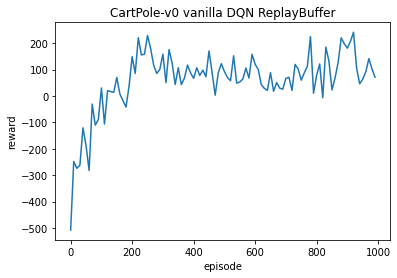

In [126]:
plt.figure()
plt.title("CartPole-v0 vanilla DQN ReplayBuffer")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_6)
plt.show()

## Double DQN with Prioritized Experience Replay Buffer and Target Network

source : https://arxiv.org/abs/1511.05952?context=cs

In [127]:
from collections import namedtuple
import typing

In [128]:
"""
Prioritized Experience Replay
"""


_field_names = [
    "state",
    "action",
    "reward",
    "done",
    "new_state"
    
]
Experience = namedtuple("Experience", field_names=_field_names)

class PrioritizedExperienceReplayBuffer:
    def __init__(self,
                 batch_size: int,
                 buffer_size: int,
                 alpha: float = 0.0,
                 random_state: np.random.RandomState = None) -> None:
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer_length = 0
        self._buffer = np.empty(self._buffer_size, dtype=[("priority", np.float32), ("experience", Experience)])
        self._alpha = alpha
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        return self._buffer_length

    def alpha(self):
        return self._alpha

    def batch_size(self) -> int:
        return self._batch_size
    
    def buffer_size(self) -> int:
        return self._buffer_size

    def add(self, experience: Experience) -> None:
        priority = 1.0 if self.is_empty() else self._buffer["priority"].max()
        if self.is_full():
            if priority > self._buffer["priority"].min():
                idx = self._buffer["priority"].argmin()
                self._buffer[idx] = (priority, experience)
            else:
                pass
        else:
            self._buffer[self._buffer_length] = (priority, experience)
            self._buffer_length += 1

    def is_empty(self) -> bool:
        return self._buffer_length == 0
    
    def is_full(self) -> bool:
        return self._buffer_length == self._buffer_size
    
    def sample(self, beta: float) -> typing.Tuple[np.array, np.array, np.array]:
        ps = self._buffer[:self._buffer_length]["priority"]
        sampling_probs = ps**self._alpha / np.sum(ps**self._alpha)
        idxs = self._random_state.choice(np.arange(ps.size),
                                         size=self._batch_size,
                                         replace=True,
                                         p=sampling_probs)
        
        experiences = self._buffer["experience"][idxs]        
        weights = (self._buffer_length * sampling_probs[idxs])**-beta
        normalized_weights = weights / weights.max()
        
        return idxs, experiences, normalized_weights

    def update_priorities(self, idxs: np.array, priorities: np.array) -> None:
        self._buffer["priority"][idxs] = priorities
        

def exponential_annealing_schedule(episode, rate=1e-2):
    return 1 - np.exp(-rate * episode)

In [129]:
def test(q_network) :
    state = env.reset()
    done = False
    cum_sum = 0
    timestep = 0
    while not done  :
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        action = torch.argmax(q_network(state_t)).item()
        new_state,reward,done,_ = env.step(action)
        state = new_state
        cum_sum += reward
        timestep +=1
        
    return cum_sum

In [130]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-3
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e5)
update_frequency = 1

tau = 1e-3 

In [131]:
replay_buffer = PrioritizedExperienceReplayBuffer(batch_size,size_replay_buffer)
q_network = QNetwork(nb_actions,nb_observations)
q_target_network = QNetwork(nb_actions,nb_observations)

q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_7 = []
timestep = 0
best_value = -1e9
average_last_test = deque(maxlen=100)

for episode in tqdm(range(nb_episode)) :
    
    epsilon = max(epsilon*epsilon_decay,epsilon_min)
    
    state = env.reset()
    
    done = False
    cumul = 0
    
    while not done : 
        
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        
        if random.random() < epsilon :
            action = torch.argmax(q_network(state_t).detach()).item()
        
        else :
            action = env.action_space.sample()
        
        new_state,reward,done,_ = env.step(action)
        cumul += reward
        
        transition = (state , action , reward , done , new_state)
        
        replay_buffer.add(transition)
        
        # epsilon = np.interp(episode, [0, epsilon_decay], [epsilon_start, epsilon_end])
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0:
            
            
            beta = exponential_annealing_schedule(episode)
            
            idxs, experiences, normalized_weights = replay_buffer.sample(beta)

            _sampling_weights = (torch.as_tensor(normalized_weights, dtype=torch.float32).view((-1, 1)))
            
            states, actions, rewards, dones ,new_states  = (vs for vs in zip(*experiences))

            states_t = torch.stack([torch.as_tensor(o,dtype=torch.float32) for o in states]).squeeze()
            actions_t = torch.as_tensor(np.array([a for a in actions]) , dtype=torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(np.array([r for r in rewards]) , dtype=torch.float32).unsqueeze(1)
            dones_t = torch.as_tensor(np.array([o for o in dones] , dtype = int) , dtype=torch.int32).unsqueeze(1)
            new_states_t = torch.stack([torch.as_tensor(o,dtype=torch.float32) for o in new_states]).squeeze()
            """
            
            batch = random.sample(replay_buffer,batch_size)

            states = np.asarray([exp[0] for exp in batch],dtype=np.float32)
            actions = np.asarray([exp[1] for exp in batch],dtype=int)
            rewards = np.asarray([exp[2] for exp in batch],dtype=np.float32)
            dones = np.asarray([exp[3] for exp in batch],dtype=int)
            new_states = np.asarray([exp[4] for exp in batch],dtype=np.float32)
            
            states_t = torch.as_tensor(states , dtype=torch.float32)
            dones_t = torch.as_tensor(dones , dtype = torch.int64).unsqueeze(1)
            new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
            actions_t = torch.as_tensor(actions , dtype = torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(rewards , dtype=torch.float32).unsqueeze(1)
            """
            
            # y_target = rewards_t + discount_factor * (1 - dones_t) * torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1))
            with torch.no_grad() :
                y_target = rewards_t + discount_factor * (1 - dones_t) * torch.max(q_target_network(new_states_t),dim=1)[0].unsqueeze(1)
            
            td_error = y_target - torch.gather(q_network(states_t),dim=1,index=actions_t)

            replay_buffer.update_priorities(idxs, td_error.abs().cpu().detach().numpy().flatten())
            
            mse = nn.MSELoss() # nn.HuberLoss()
            q_values = torch.gather(q_network(states_t),dim=1,index=actions_t)
            
            loss =  mse(y_target * _sampling_weights,q_values*_sampling_weights)

            # loss = - (torch.gather(q_network(states_t),dim=1,index=actions_t)*_sampling_weights*td_error.detach()).sum()#
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
        timestep += 1
        
        state = new_state
        
    average_last_test.append(cumul)
    
    if episode % test_frequency == 0 :
        t =  0
        for _ in range(10) :
            t += test(q_network)
        t /= 10
        
        average = sum(average_last_test) / len(average_last_test)
        if t > best_value :
            print("test new best value : ",t," eps : ",epsilon,"avg : ",average)
            best_value = t
        else :
            print("test : ",t," eps : ",epsilon,"avg :",average)
        list_tests_7.append(t)
        

  0%|                                          | 1/1000 [00:00<08:13,  2.02it/s]

test new best value :  -824.0905497397587  eps :  0.995 avg :  -128.61917964746524


  1%|▍                                        | 11/1000 [00:05<12:08,  1.36it/s]

test new best value :  -157.9178684934471  eps :  0.946354579813443 avg :  -260.7523249412523


  2%|▊                                        | 21/1000 [00:14<16:55,  1.04s/it]

test :  -171.8284041097567  eps :  0.9000874278732445 avg : -212.00635505188444


  3%|█▏                                     | 31/1000 [00:49<1:56:44,  7.23s/it]

test new best value :  -89.19633632080011  eps :  0.8560822709551227 avg :  -190.88895023928924


  4%|█▌                                     | 41/1000 [01:38<1:43:37,  6.48s/it]

test :  -117.25346704101199  eps :  0.8142285204175609 avg : -163.91938381104043


  5%|█▉                                     | 51/1000 [02:18<1:25:53,  5.43s/it]

test new best value :  -83.74608471726405  eps :  0.7744209942832988 avg :  -155.03245750972042


  6%|██▍                                    | 61/1000 [03:06<1:14:08,  4.74s/it]

test :  -128.5630218163255  eps :  0.736559652908221 avg : -153.5497829151711


  7%|██▊                                    | 71/1000 [03:45<1:19:22,  5.13s/it]

test :  -115.22204993211899  eps :  0.7005493475733617 avg : -151.31146978950017


  8%|███▏                                   | 81/1000 [04:20<1:37:18,  6.35s/it]

test new best value :  -68.35810222883842  eps :  0.6662995813682115 avg :  -145.71326214779984


  9%|███▌                                   | 91/1000 [04:53<1:09:07,  4.56s/it]

test new best value :  -63.51112742045702  eps :  0.6337242817644086 avg :  -138.92222442927877


 10%|███▊                                  | 101/1000 [05:13<1:00:36,  4.05s/it]

test :  -98.19778965649049  eps :  0.6027415843082742 avg : -134.0829173459805


 11%|████▏                                 | 111/1000 [05:37<1:09:32,  4.69s/it]

test new best value :  -49.854822121578295  eps :  0.5732736268885887 avg :  -111.79674266709604


 12%|████▊                                   | 121/1000 [05:49<15:51,  1.08s/it]

test :  -69.5731504881652  eps :  0.5452463540625918 avg : -101.70632465957115


 13%|█████▏                                  | 131/1000 [06:05<52:33,  3.63s/it]

test new best value :  -48.24861202615661  eps :  0.5185893309484582 avg :  -92.17822346272531


 14%|█████▎                                | 141/1000 [06:27<1:16:21,  5.33s/it]

test :  -66.0356979861733  eps :  0.4932355662165453 avg : -87.43285785085084


 15%|█████▋                                | 151/1000 [06:50<1:10:18,  4.97s/it]

test new best value :  -35.032706166223406  eps :  0.46912134373457726 avg :  -80.80237586686503


 16%|██████▍                                 | 161/1000 [07:03<40:54,  2.93s/it]

test :  -40.74794712197735  eps :  0.446186062443672 avg : -71.23952707302655


 17%|██████▍                               | 171/1000 [07:25<1:00:23,  4.37s/it]

test :  -63.33206940004625  eps :  0.42437208406280985 avg : -61.54651005226967


 18%|██████▉                               | 181/1000 [07:47<1:08:08,  4.99s/it]

test :  -64.02072861336795  eps :  0.4036245882390106 avg : -56.12844780841186


 19%|███████▎                              | 191/1000 [08:08<1:08:19,  5.07s/it]

test :  -82.83238201201843  eps :  0.38389143477919885 avg : -51.88724830962555


 20%|████████                                | 201/1000 [08:24<53:23,  4.01s/it]

test :  -64.74499007358177  eps :  0.36512303261753626 avg : -47.36737243123608


 21%|████████                              | 211/1000 [08:43<1:00:00,  4.56s/it]

test :  -64.48693406503271  eps :  0.3472722151889232 avg : -50.58313708948938


 22%|████████▊                               | 221/1000 [09:01<59:58,  4.62s/it]

test :  -104.49500182587879  eps :  0.3302941218954743 avg : -51.68021603603152


 23%|█████████▏                              | 231/1000 [09:18<53:31,  4.18s/it]

test new best value :  1.7858864842801  eps :  0.3141460853680822 avg :  -53.662143519534105


 24%|█████████▏                            | 241/1000 [09:39<1:07:54,  5.37s/it]

test :  -73.89787486765009  eps :  0.2987875242397482 avg : -55.84891292156672


 25%|██████████                              | 251/1000 [09:56<53:20,  4.27s/it]

test :  -47.354413627247624  eps :  0.28417984116121187 avg : -58.39600556990035


 26%|██████████▍                             | 261/1000 [10:12<47:39,  3.87s/it]

test :  -18.464634538420064  eps :  0.2702863258025825 avg : -61.21592090670622


 27%|██████████▎                           | 271/1000 [10:31<1:00:25,  4.97s/it]

test :  -40.447806618417395  eps :  0.2570720625972084 avg : -62.720835951966876


 28%|███████████▏                            | 281/1000 [10:44<36:32,  3.05s/it]

test :  -52.373888298993336  eps :  0.24450384299593592 avg : -65.68439185526375


 29%|███████████▋                            | 291/1000 [11:03<58:50,  4.98s/it]

test :  -35.111904589507006  eps :  0.23255008201124722 avg : -70.45497369113788


 30%|████████████                            | 301/1000 [11:20<51:33,  4.43s/it]

test :  -84.4836191987129  eps :  0.2211807388415433 avg : -73.60242838194335


 31%|████████████▍                           | 311/1000 [11:34<39:19,  3.42s/it]

test :  -52.88498002355959  eps :  0.21036724137609603 avg : -72.13825937316238


 32%|████████████▊                           | 321/1000 [11:48<40:23,  3.57s/it]

test :  -113.86412958499932  eps :  0.2000824143909432 avg : -73.60150377914721


 33%|█████████████▏                          | 331/1000 [12:08<56:45,  5.09s/it]

test :  -34.40572397870426  eps :  0.1903004112552766 avg : -76.04999811211945


 34%|█████████████▋                          | 341/1000 [12:26<49:38,  4.52s/it]

test :  -36.01067648040244  eps :  0.18099664897669618 avg : -80.88364282001737


 35%|██████████████                          | 351/1000 [12:46<55:31,  5.13s/it]

test :  -41.338778132735015  eps :  0.17214774642209296 avg : -81.12887357475817


 36%|██████████████▍                         | 361/1000 [13:05<50:28,  4.74s/it]

test :  -42.47373633608474  eps :  0.16373146555890544 avg : -84.65078813559013


 37%|██████████████▊                         | 371/1000 [13:24<52:07,  4.97s/it]

test :  -36.352473862359126  eps :  0.1557266555690826 avg : -94.25328776926632


 38%|███████████████▏                        | 381/1000 [13:45<54:22,  5.27s/it]

test :  -60.67846204265389  eps :  0.14811319969530845 avg : -97.82293914014132


 39%|███████████████▋                        | 391/1000 [14:05<54:44,  5.39s/it]

test :  -36.68327905909281  eps :  0.14087196468590776 avg : -99.2373497310398


 40%|████████████████                        | 401/1000 [14:23<46:48,  4.69s/it]

test :  -20.03526237388998  eps :  0.13398475271138335 avg : -103.80612092728262


 41%|████████████████▍                       | 411/1000 [14:43<50:04,  5.10s/it]

test :  -2.338089275451545  eps :  0.12743425563174798 avg : -111.4259006313547


 42%|████████████████▊                       | 421/1000 [15:04<51:33,  5.34s/it]

test new best value :  25.58167924686992  eps :  0.12120401149972035 avg :  -113.7447386230246


 43%|█████████████████▏                      | 431/1000 [15:17<32:21,  3.41s/it]

test :  -55.62223547524544  eps :  0.11527836319047392 avg : -114.85565365429116


 44%|█████████████████▋                      | 441/1000 [15:35<42:37,  4.57s/it]

test :  -100.81817973104542  eps :  0.10964241905397228 avg : -113.45763593884709


 45%|██████████████████                      | 451/1000 [15:47<23:52,  2.61s/it]

test :  -153.73635688525184  eps :  0.1042820154910064 avg : -122.7218057667534


 46%|██████████████████▍                     | 461/1000 [16:08<49:41,  5.53s/it]

test :  -33.19996960838151  eps :  0.09918368135888474 avg : -121.53086086371707


 47%|██████████████████▊                     | 471/1000 [16:30<50:20,  5.71s/it]

test :  -47.67453122233633  eps :  0.0943346041173244 avg : -116.87741687412498


 48%|███████████████████▏                    | 481/1000 [16:55<53:38,  6.20s/it]

test :  -23.170578431776924  eps :  0.08972259762946533 avg : -114.66435045179036


 49%|███████████████████▋                    | 491/1000 [17:15<43:06,  5.08s/it]

test :  -67.5872207734835  eps :  0.08533607153708872 avg : -117.50067505980184


 50%|████████████████████                    | 501/1000 [17:34<36:00,  4.33s/it]

test new best value :  90.13496875684518  eps :  0.0811640021330769 avg :  -117.29467733665147


 51%|████████████████████▍                   | 511/1000 [17:55<40:44,  5.00s/it]

test :  -127.27905753531184  eps :  0.07719590465791494 avg : -112.13338072156974


 52%|████████████████████▊                   | 521/1000 [18:11<31:36,  3.96s/it]

test :  -131.6122141360542  eps :  0.07342180695061275 avg : -116.86465036792082


 53%|█████████████████████▏                  | 531/1000 [18:25<25:08,  3.22s/it]

test :  -118.2747659595597  eps :  0.06983222438783 avg : -121.78948169852663


 54%|█████████████████████▋                  | 541/1000 [18:38<20:41,  2.71s/it]

test :  87.82503855327802  eps :  0.06641813604822402 avg : -126.80775526325235


 55%|██████████████████████                  | 551/1000 [18:50<19:49,  2.65s/it]

test :  -16.61336076470845  eps :  0.06317096204211972 avg : -124.94207478433859


 56%|██████████████████████▍                 | 561/1000 [19:12<39:51,  5.45s/it]

test :  -69.42209001311646  eps :  0.06008254194952879 avg : -124.07757766891056


 57%|██████████████████████▊                 | 571/1000 [19:26<25:44,  3.60s/it]

test :  -161.14601096166334  eps :  0.05714511431233153 avg : -130.31338218524752


 58%|███████████████████████▏                | 581/1000 [19:35<11:14,  1.61s/it]

test :  -102.23089434915371  eps :  0.0543512971290831 avg : -139.07409514360256


 59%|███████████████████████▋                | 591/1000 [19:48<14:36,  2.14s/it]

test :  -85.53868495092232  eps :  0.05169406930342616 avg : -138.59453018435588


 60%|████████████████████████                | 601/1000 [20:00<18:09,  2.73s/it]

test :  0.9358338576604993  eps :  0.04916675299948831 avg : -144.6335032365979


 61%|████████████████████████▍               | 611/1000 [20:30<27:38,  4.26s/it]

test :  -132.2912797511727  eps :  0.04676299685992172 avg : -149.1300694010972


 62%|████████████████████████▊               | 621/1000 [20:42<10:57,  1.74s/it]

test :  -47.159204186169816  eps :  0.04447676004441063 avg : -147.5124541966839


 63%|█████████████████████████▏              | 631/1000 [21:22<41:39,  6.77s/it]

test :  -37.036906300170536  eps :  0.04230229704853423 avg : -144.9158108853069


 64%|█████████████████████████▋              | 641/1000 [21:48<25:31,  4.27s/it]

test new best value :  110.14335590464847  eps :  0.04023414326483323 avg :  -143.6954807877787


 65%|██████████████████████████              | 651/1000 [22:23<41:28,  7.13s/it]

test :  -109.87359851575408  eps :  0.03826710124979409 avg : -141.0326324521156


 66%|██████████████████████████▍             | 661/1000 [22:51<22:17,  3.94s/it]

test :  53.03869264687789  eps :  0.036396227662238566 avg : -144.42942881873248


 67%|██████████████████████████▊             | 671/1000 [23:19<24:33,  4.48s/it]

test :  -203.5817995968813  eps :  0.03461682084029365 avg : -144.4844879246769


 68%|███████████████████████████▏            | 681/1000 [23:51<22:39,  4.26s/it]

test :  29.18227494949364  eps :  0.032924408985721944 avg : -141.54811409690038


 69%|███████████████████████████▋            | 691/1000 [24:29<31:09,  6.05s/it]

test :  -56.928294922972086  eps :  0.03131473892591842 avg : -145.34386598804713


 70%|████████████████████████████            | 701/1000 [24:52<17:15,  3.46s/it]

test :  -92.18468821005756  eps :  0.029783765425331846 avg : -144.6944966450778


 71%|████████████████████████████▍           | 711/1000 [25:23<23:51,  4.95s/it]

test :  -161.4861186521726  eps :  0.02832764101944931 avg : -149.06798554892492


 72%|████████████████████████████▊           | 721/1000 [26:00<20:43,  4.46s/it]

test new best value :  132.9277276067904  eps :  0.02694270634579598 avg :  -149.84530195993366


 73%|█████████████████████████████▏          | 731/1000 [26:38<25:17,  5.64s/it]

test :  -201.49403010194638  eps :  0.02562548094765099 avg : -151.93865350527636


 74%|█████████████████████████████▋          | 741/1000 [27:00<10:59,  2.55s/it]

test :  -266.36657076933693  eps :  0.02437265452736848 avg : -156.6930814252297


 75%|██████████████████████████████          | 751/1000 [27:28<13:55,  3.36s/it]

test :  17.679241964163005  eps :  0.023181078627322618 avg : -168.43104777820488


 76%|██████████████████████████████▍         | 761/1000 [28:03<21:12,  5.32s/it]

test :  63.59989615526873  eps :  0.022047758717570132 avg : -175.18925230829117


 77%|██████████████████████████████▊         | 771/1000 [28:44<17:52,  4.68s/it]

test :  -249.55490048089078  eps :  0.020969846670345987 avg : -179.70813046759437


 78%|███████████████████████████████▏        | 781/1000 [29:13<07:18,  2.00s/it]

test :  -202.90466011029906  eps :  0.02 avg : -181.0957896944168


 79%|███████████████████████████████▋        | 791/1000 [29:41<14:54,  4.28s/it]

test :  -62.05410519833672  eps :  0.02 avg : -180.29751044251566


 80%|████████████████████████████████        | 801/1000 [29:58<06:54,  2.09s/it]

test :  -237.92966843478334  eps :  0.02 avg : -174.93598219065308


 81%|████████████████████████████████▍       | 811/1000 [30:13<06:02,  1.92s/it]

test :  -182.27900051959767  eps :  0.02 avg : -172.26998406470742


 82%|████████████████████████████████▊       | 821/1000 [30:27<04:34,  1.53s/it]

test :  50.62084086993015  eps :  0.02 avg : -175.0249577469339


 83%|█████████████████████████████████▏      | 831/1000 [30:38<04:54,  1.74s/it]

test :  -156.95373475280923  eps :  0.02 avg : -175.1684718182492


 84%|█████████████████████████████████▋      | 841/1000 [30:50<05:08,  1.94s/it]

test :  -211.61495741900808  eps :  0.02 avg : -176.40230171125353


 85%|██████████████████████████████████      | 851/1000 [31:00<03:08,  1.26s/it]

test :  -181.8182836891826  eps :  0.02 avg : -169.30630610381937


 86%|██████████████████████████████████▍     | 861/1000 [31:11<03:14,  1.40s/it]

test :  -99.10996741640352  eps :  0.02 avg : -163.92496278762576


 87%|██████████████████████████████████▊     | 871/1000 [31:21<03:49,  1.78s/it]

test :  79.39799790827877  eps :  0.02 avg : -159.05863713090284


 88%|███████████████████████████████████▏    | 881/1000 [31:41<07:50,  3.95s/it]

test :  -170.85791061324875  eps :  0.02 avg : -158.8299085536818


 89%|███████████████████████████████████▋    | 891/1000 [31:53<03:47,  2.09s/it]

test :  -82.25754897862457  eps :  0.02 avg : -157.04837518869678


 90%|████████████████████████████████████    | 901/1000 [32:11<04:12,  2.55s/it]

test :  7.277190556327478  eps :  0.02 avg : -162.48300300471254


 91%|████████████████████████████████████▍   | 911/1000 [32:27<04:54,  3.31s/it]

test :  -185.61448821233142  eps :  0.02 avg : -161.54861518688278


 92%|████████████████████████████████████▊   | 921/1000 [32:39<01:48,  1.37s/it]

test :  -175.51850742160218  eps :  0.02 avg : -168.12582341244672


 93%|█████████████████████████████████████▏  | 931/1000 [32:51<01:50,  1.60s/it]

test :  -5.013998211262868  eps :  0.02 avg : -165.62699290929646


 94%|█████████████████████████████████████▋  | 941/1000 [33:02<01:46,  1.81s/it]

test :  -61.86335502050897  eps :  0.02 avg : -157.64803441274674


 95%|██████████████████████████████████████  | 951/1000 [33:13<01:25,  1.74s/it]

test :  -59.30590747977035  eps :  0.02 avg : -156.43351945722824


 96%|██████████████████████████████████████▍ | 961/1000 [33:23<00:54,  1.39s/it]

test new best value :  151.96888693576756  eps :  0.02 avg :  -155.89211821383245


 97%|██████████████████████████████████████▊ | 971/1000 [33:33<00:45,  1.56s/it]

test :  -21.613347821009807  eps :  0.02 avg : -155.53455934235632


 98%|███████████████████████████████████████▏| 981/1000 [33:44<00:37,  1.97s/it]

test new best value :  155.6121184478274  eps :  0.02 avg :  -156.70412242567224


 99%|███████████████████████████████████████▋| 991/1000 [33:51<00:08,  1.08it/s]

test :  -223.90299758957408  eps :  0.02 avg : -161.55625948922773


100%|███████████████████████████████████████| 1000/1000 [33:56<00:00,  2.04s/it]


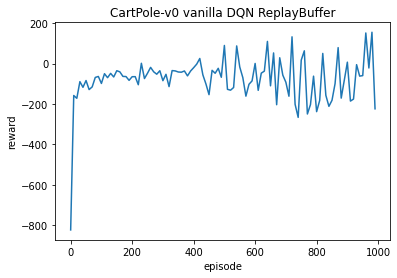

In [132]:
plt.figure()
plt.title("CartPole-v0 vanilla DQN ReplayBuffer")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_7)
plt.show()

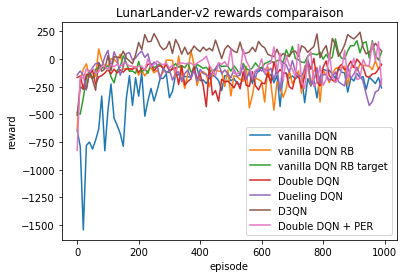

In [135]:
plt.figure()
plt.title("LunarLander-v2 rewards comparaison")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_1,label="vanilla DQN")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_2,label="vanilla DQN RB")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_3,label="vanilla DQN RB target")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_4,label="Double DQN")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_5,label="Dueling DQN")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_6,label="D3QN")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_7,label="Double DQN + PER")
plt.legend()
plt.show()

## D3QN with Prioritized Experience Replay Buffer and Target Network

In [97]:
nb_episode = 1000

discount_factor = 0.99
learning_rate = 2e-4
test_frequency = 10
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.02
batch_size = 64
size_replay_buffer = int(1e6)
update_frequency = 4

tau = 1e-3 

In [98]:
replay_buffer = PrioritizedExperienceReplayBuffer(batch_size,size_replay_buffer)
q_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network = DuelingQNetwork(nb_actions,nb_observations)
q_target_network.load_state_dict(q_network.state_dict())
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)
list_tests_8 = []
timestep = 0

average_list = deque(maxlen=100)

for episode in tqdm(range(nb_episode)) :
    state = env.reset()
    done = False
    
    cumul = 0
    epsilon = max(epsilon * epsilon_decay,epsilon_min)
    
    while not done : 
        state_t = torch.as_tensor(state , dtype = torch.float32).unsqueeze(0)
        
        if random.random() < epsilon :
            action = torch.argmax(q_network(state_t)).item()
        else :
            action = env.action_space.sample()
            
        new_state,reward,done,_ = env.step(action)

        cumul += reward
        
        transition = (state,action,done,reward,new_state)
        
        replay_buffer.add(transition)
        
        if len(replay_buffer) >= batch_size and timestep % update_frequency == 0 :
        
            beta = exponential_annealing_schedule(episode)
            
            idxs, experiences, normalized_weights = replay_buffer.sample(beta)

            _sampling_weights = (torch.as_tensor(normalized_weights, dtype=torch.float32).view((-1, 1)))
            
            states, actions, rewards, dones ,new_states  = (vs for vs in zip(*experiences))

            states_t = torch.stack([torch.as_tensor(o,dtype=torch.float32) for o in states]).squeeze()
            actions_t = torch.as_tensor(np.array([a for a in actions]) , dtype=torch.int64).unsqueeze(1)
            rewards_t = torch.as_tensor(np.array([r for r in rewards]) , dtype=torch.float32).unsqueeze(1)
            dones_t = torch.as_tensor(np.array([o for o in dones] , dtype = int) , dtype=torch.int32).unsqueeze(1)
            new_states_t = torch.stack([torch.as_tensor(o,dtype=torch.float32) for o in new_states]).squeeze()
            
            with torch.no_grad() :
                y_target = rewards_t + discount_factor * (1 - dones_t) * torch.gather(q_target_network(new_states_t),dim=1,index=torch.argmax(q_network(new_states_t),dim=1).unsqueeze(1)).detach()

            td_error = y_target - torch.gather(q_network(states_t),dim=1,index=actions_t)

            replay_buffer.update_priorities(idxs, td_error.abs().cpu().detach().numpy().flatten())
            
            mse = nn.MSELoss()
            q_values = torch.gather(q_network(states_t),dim=1,index=actions_t)
            loss =  mse(y_target * _sampling_weights,q_values*_sampling_weights)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for target_param, local_param in zip(q_target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)  
                
        timestep += 1
        
        state = new_state
        
    
    average_list.append(cumul)
    
    if episode % test_frequency == 0 :
        t = test(q_network)
        avg = sum(average_list) / len(average_list)
        print(f"episode {episode} - test reward : {t} - avg : {avg} - epsilon {epsilon}")
        list_tests_8.append(t)

  0%|                                          | 2/1000 [00:00<02:48,  5.92it/s]

episode 0 - test reward : -413.1218396827109 - avg : -516.2993149398748 - epsilon 0.995


  1%|▍                                        | 11/1000 [00:02<03:36,  4.58it/s]

episode 10 - test reward : -775.8028601222709 - avg : -528.3330767873905 - epsilon 0.946354579813443


  2%|▉                                        | 22/1000 [00:04<03:35,  4.53it/s]

episode 20 - test reward : -463.8887655593392 - avg : -531.6993100454366 - epsilon 0.9000874278732445


  3%|█▎                                       | 32/1000 [00:07<03:48,  4.23it/s]

episode 30 - test reward : -977.4845331466854 - avg : -535.5758470160247 - epsilon 0.8560822709551227


  4%|█▋                                       | 41/1000 [00:09<04:50,  3.30it/s]

episode 40 - test reward : -525.0241921223983 - avg : -522.6423062841859 - epsilon 0.8142285204175609


  5%|██                                       | 51/1000 [00:13<04:54,  3.22it/s]

episode 50 - test reward : -784.8326175740593 - avg : -524.896862426622 - epsilon 0.7744209942832988


  6%|██▌                                      | 61/1000 [00:17<06:48,  2.30it/s]

episode 60 - test reward : -775.8571595057435 - avg : -536.2190916849077 - epsilon 0.736559652908221


  7%|██▉                                      | 71/1000 [00:21<07:01,  2.20it/s]

episode 70 - test reward : -799.3315236663722 - avg : -538.0908595181756 - epsilon 0.7005493475733617


  8%|███▎                                     | 81/1000 [00:25<07:00,  2.19it/s]

episode 80 - test reward : -1492.7684162755 - avg : -558.9514687617805 - epsilon 0.6662995813682115


  9%|███▋                                     | 91/1000 [00:29<05:23,  2.81it/s]

episode 90 - test reward : -509.06756627191186 - avg : -561.198683430127 - epsilon 0.6337242817644086


 10%|████                                    | 101/1000 [00:34<07:00,  2.14it/s]

episode 100 - test reward : -1140.2111141781063 - avg : -570.747376747693 - epsilon 0.6027415843082742


 11%|████▍                                   | 111/1000 [00:38<05:19,  2.78it/s]

episode 110 - test reward : -933.351866376944 - avg : -564.36868588 - epsilon 0.5732736268885887


 12%|████▊                                   | 121/1000 [00:41<04:02,  3.62it/s]

episode 120 - test reward : -370.9251840614987 - avg : -556.2341663015559 - epsilon 0.5452463540625918


 13%|█████▏                                  | 131/1000 [00:44<03:43,  3.89it/s]

episode 130 - test reward : -514.3191762072321 - avg : -551.4896371318829 - epsilon 0.5185893309484582


 14%|█████▋                                  | 141/1000 [00:47<03:36,  3.97it/s]

episode 140 - test reward : -831.9345084768058 - avg : -544.9880009569645 - epsilon 0.4932355662165453


 15%|██████                                  | 151/1000 [00:49<03:47,  3.74it/s]

episode 150 - test reward : -951.477835097958 - avg : -535.986265722918 - epsilon 0.46912134373457726


 16%|██████▍                                 | 162/1000 [00:52<04:26,  3.14it/s]

episode 160 - test reward : -838.6075564546722 - avg : -519.5438368278242 - epsilon 0.446186062443672


 17%|██████▊                                 | 171/1000 [00:55<04:26,  3.11it/s]

episode 170 - test reward : -538.6134492272736 - avg : -499.1369128065078 - epsilon 0.42437208406280985


KeyboardInterrupt: 

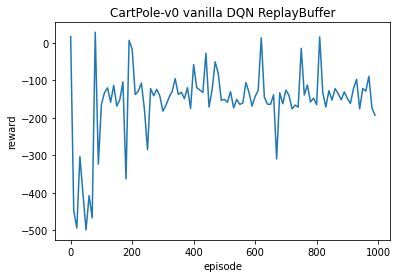

In [96]:
plt.figure()
plt.title("CartPole-v0 vanilla DQN ReplayBuffer")
plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_8)
plt.show()

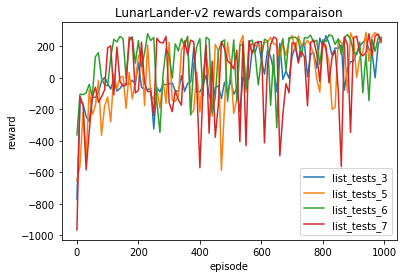

In [74]:
plt.figure()
plt.title("LunarLander-v2 rewards comparaison")
plt.xlabel("episode")
plt.ylabel("reward")
# plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_1,label="list_tests_1")
# plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_2,label="list_tests_2")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_3,label="list_tests_3")
# plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_4,label="list_tests_4")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_5,label="list_tests_5")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_6,label="list_tests_6")
plt.plot(np.arange(0,nb_episode,test_frequency),list_tests_7,label="list_tests_7")
plt.legend()
plt.show()